In [1]:
import pandas as pd
import numpy as np
import glob
import re
import seaborn as sns 
import matplotlib.pyplot as plt

## General visualizations of Eye tracker data health

In [3]:
data_frame = pd.read_csv("/Volumes/TwoTeras/1_Experiment_2/Eye_Tracking/Pre_processed/Data_Sets/Complete_Data_AngularV.cvs")

In [94]:
my_categories = {'Global_Landmark': '#e2514a', 
                 'TaskBuilding_Public': '#fca55d',
                'TaskBuilding_Residential': '#fee999',
                'Active_Agent': '#a2d9a4',
                'Passive_Agent': '#47a0b3'}

In [4]:
data_frame.head()

,Unnamed: 0,level_0,index,SubjectID,Session,SessionSubsection,timeStampDataPointEnd,combinedGazeValidityBitmask,eyePositionCombinedWorld.x,eyePositionCombinedWorld.y,...,combined_vel,thresh,isFix,corrected_vel,events,length,distance,avg_dist,names,Collider_CategoricalN
0,0,0,0,1031,1,1,1.668436e+09,3,-59.062084,2.408754,...,NaN,42.933244,NaN,NaN,NaN,NaN,NaN,NaN,pavement_O.002,Background
1,1,1,1,1031,1,1,1.668436e+09,3,-59.062084,2.408754,...,0.000000,42.933244,0.0,NaN,2.0,0.011408,6.394362,6.394362,pavement_O.002,Background
2,2,2,2,1031,1,1,1.668436e+09,3,-59.062084,2.408754,...,0.000000,42.933244,0.0,NaN,-2.0,0.011408,6.394362,6.394362,pavement_O.002,Background
3,3,3,3,1031,1,1,1.668436e+09,3,-59.003208,2.408757,...,144.818129,42.933244,NaN,144.818129,-1.0,0.021328,NaN,NaN,pavement_O.002,Background
4,4,4,4,1031,1,1,1.668436e+09,3,-59.003208,2.408757,...,0.000000,42.933244,0.0,0.000000,2.0,0.183023,6.577809,6.585500,pavement_O.002,Background


In [4]:
# Just if I wanted to keep only complete cases 
#Mask_IDs = data_frame['SubjectID'].isin([479, 2361, 3246, 3572, 3976, 5238, 5531, 7264, 8695])
#data_frame_final = data_frame.loc[~Mask_IDs]

In [5]:
data_frame.combinedGazeValidityBitmask.value_counts(normalize=True)

3    0.942763
0    0.057237
Name: combinedGazeValidityBitmask, dtype: float64

In [6]:
Blinks = pd.DataFrame(data_frame.groupby(["SubjectID", "Session"])["combinedGazeValidityBitmask"].value_counts(normalize=True))
Blinks.rename(columns ={"combinedGazeValidityBitmask": "Percentage"}, inplace=True)
Blinks.reset_index(inplace=True)
Blinks.loc[:, 'Validity'] = Blinks['combinedGazeValidityBitmask'].replace( {3:"Valid", 0:"Invalid"})

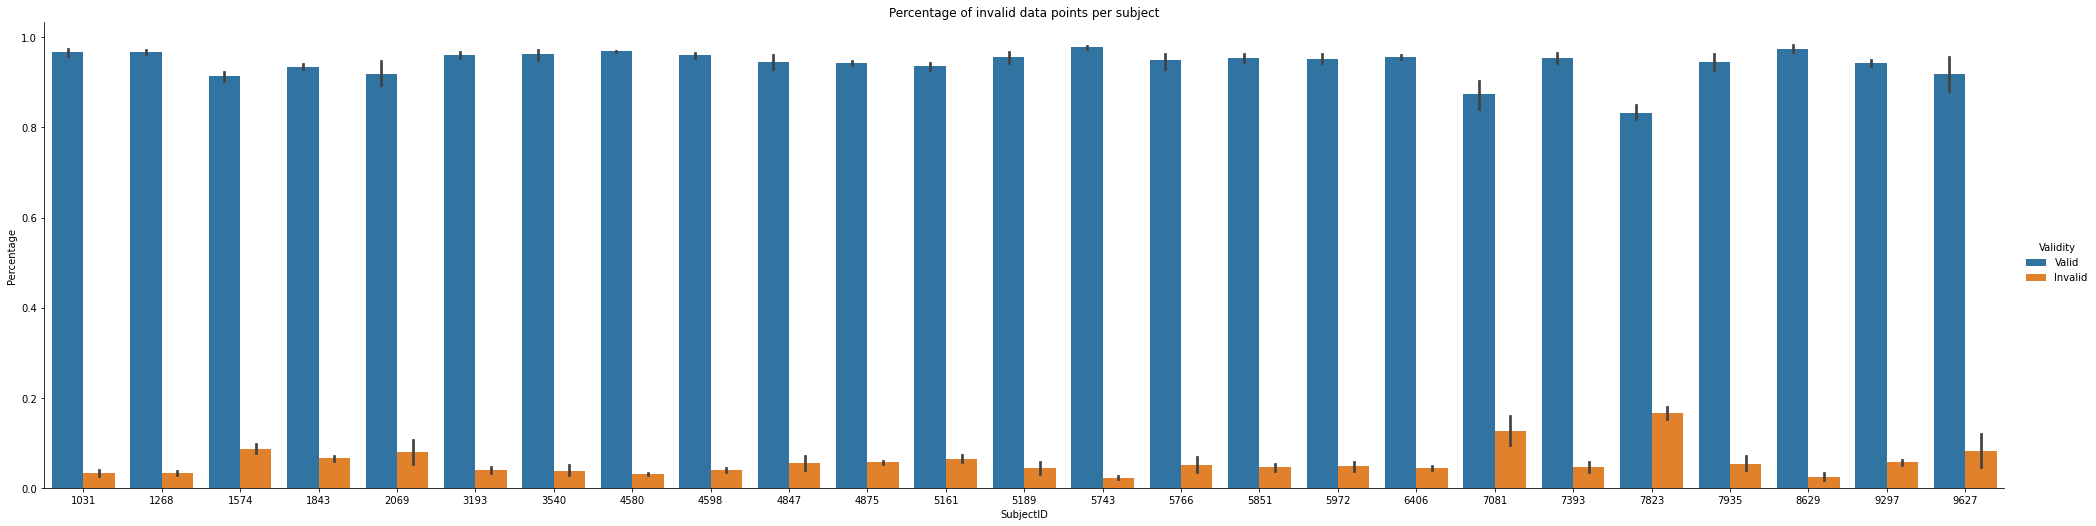

In [7]:
sns.catplot(data=Blinks, hue="Validity", y="Percentage", x="SubjectID", kind="bar", \
            height=7, aspect=4).set(title="Percentage of invalid data points per subject")

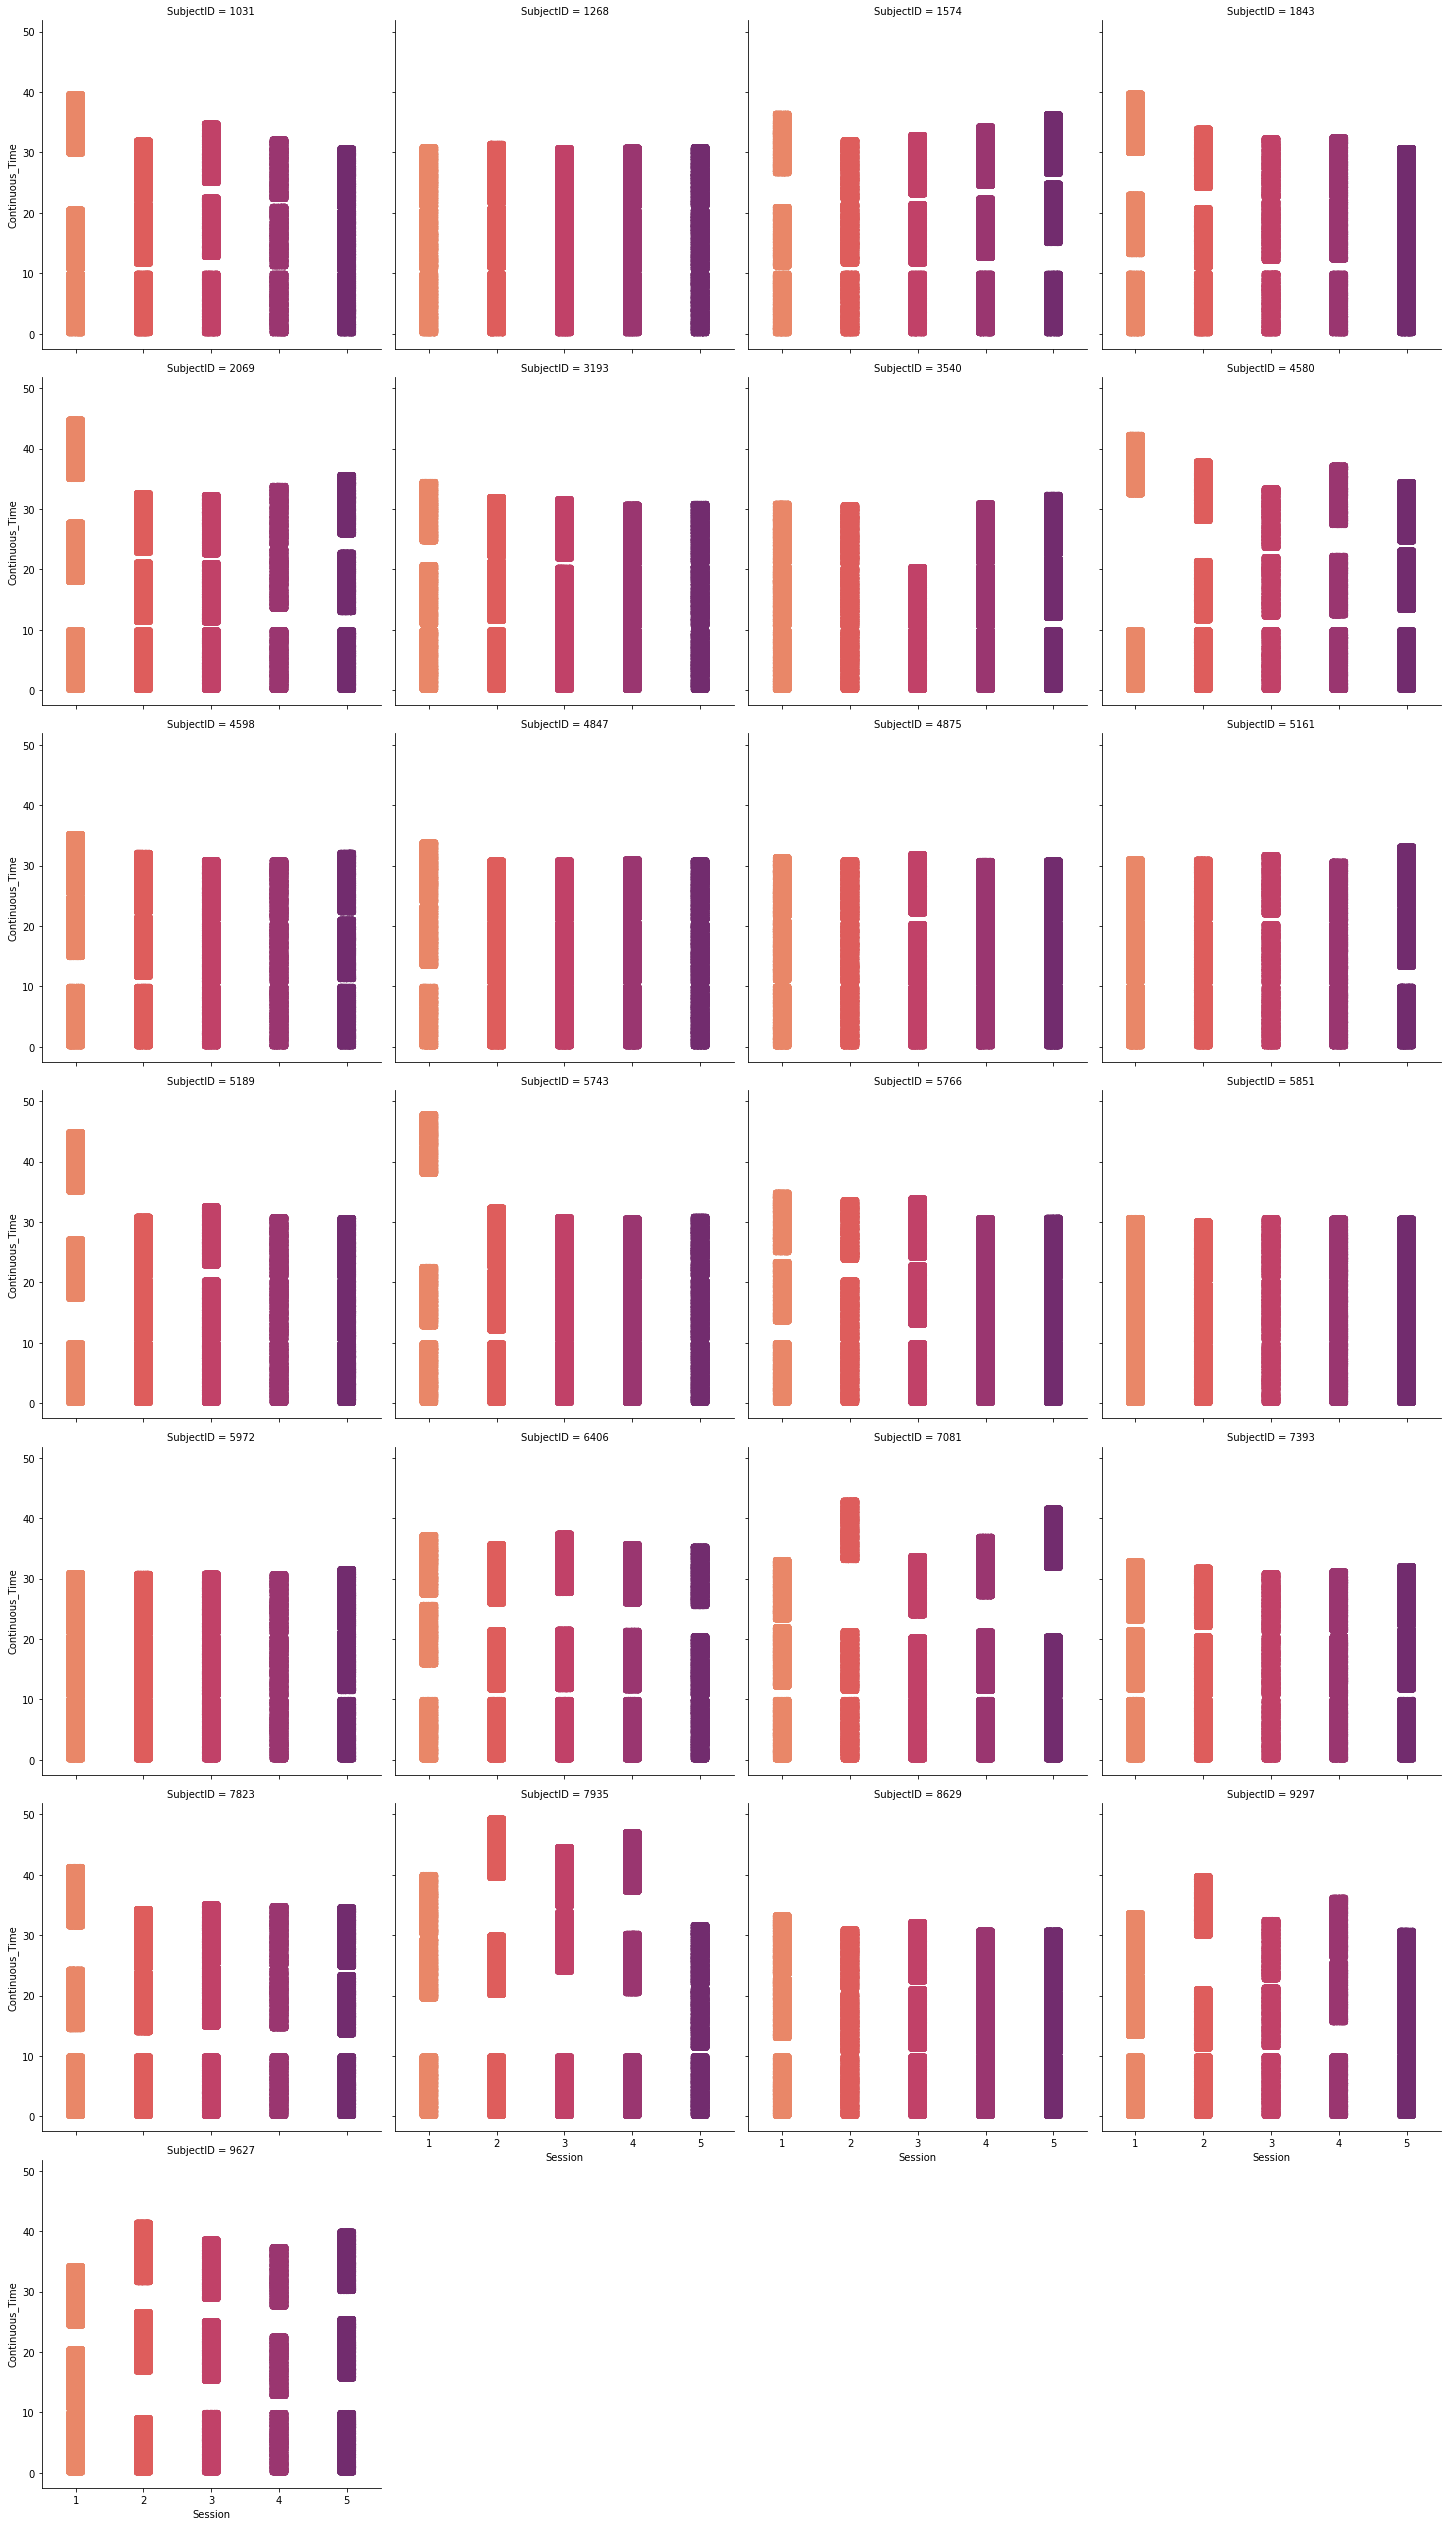

In [8]:
plot = data_frame[data_frame.Continuous_Time < 120]
sns.catplot(data=plot, col="SubjectID", y="Continuous_Time", x="Session",  col_wrap=4, palette="flare")

## Gaze processing

In [5]:
# Take  final row per fixation (the duration, average distance is the same all through the rows of the same fixation)
gaze = data_frame[data_frame.events == -2].copy()

### Get all gazes whose duration is more than 3.5 median standard deviations out 

In [6]:
gaze["Median_Standard_Duration"] = np.nanmedian(abs(gaze.length - np.nanmedian(gaze.length))) * 1.4826
gaze.loc[:, "gaze_mad_z"] = abs(gaze.length.tolist() - np.nanmedian(gaze.length)) / gaze.Median_Standard_Duration.tolist()
gaze.loc[:,"Outlier_Gaze_Length"] = np.where(gaze["gaze_mad_z"] > 3.5, "Out", "Stays")
gaze_no_out = gaze[gaze.Outlier_Gaze_Length != "Out"].copy()
gaze_no_out.to_csv("/Volumes/TwoTeras/0_Experiment_1/Eye_Tracking/Pre_processed/Data_Sets/Complete_Data_AngularV_NO_Outliers.cvs")

In [7]:
gaze.Outlier_Gaze_Length.value_counts(normalize=True)

Stays    0.955387
Out      0.044613
Name: Outlier_Gaze_Length, dtype: float64

In [8]:
# See how many data points we're loosing by excluding outliers 
display(gaze.shape)
display(gaze_no_out.shape)

(714384, 50)

(682513, 50)

### Gaze Visualizations on complete data 

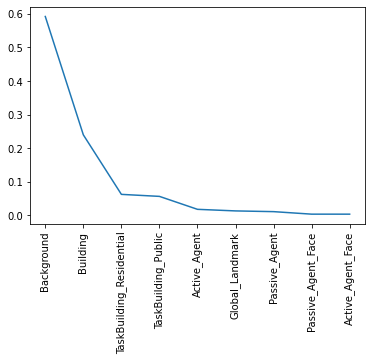

In [9]:
ax = gaze_no_out.Collider_CategoricalN.value_counts(normalize=True).plot()
ax.tick_params(axis='x', labelrotation = 90)

In [114]:
#General plotting settings
sns.set(rc={"figure.figsize":(20, 15)})
sns.set(font_scale = 1.3)
plt.tight_layout()

<Figure size 1440x1080 with 0 Axes>

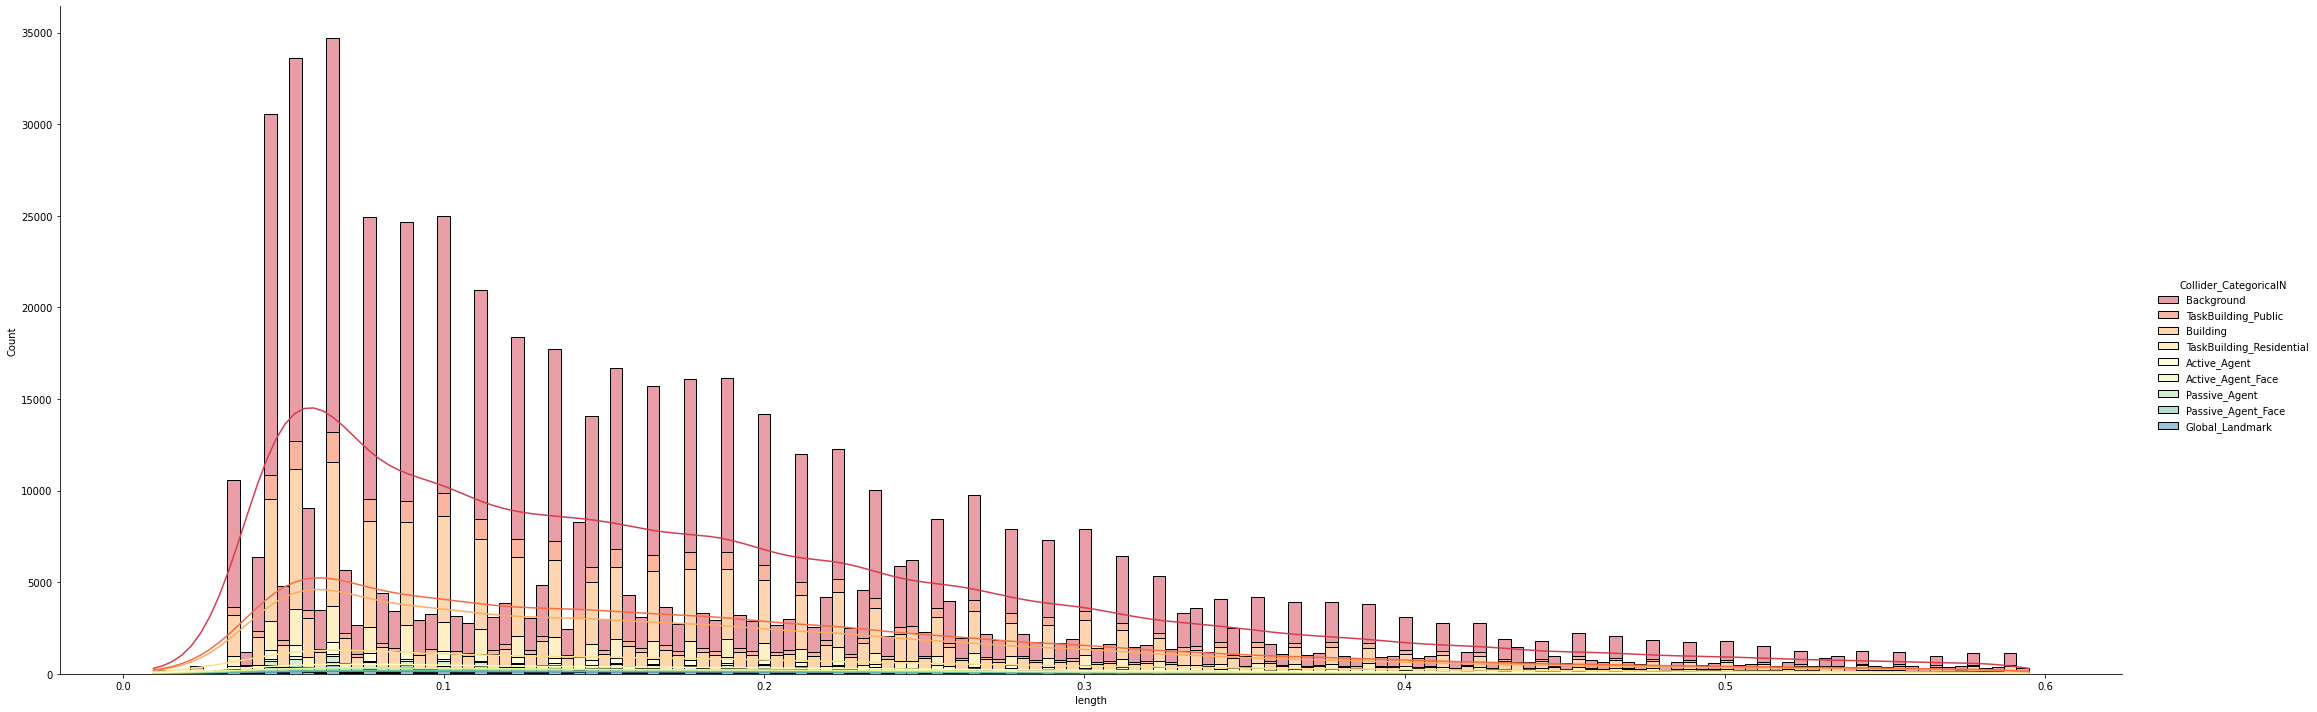

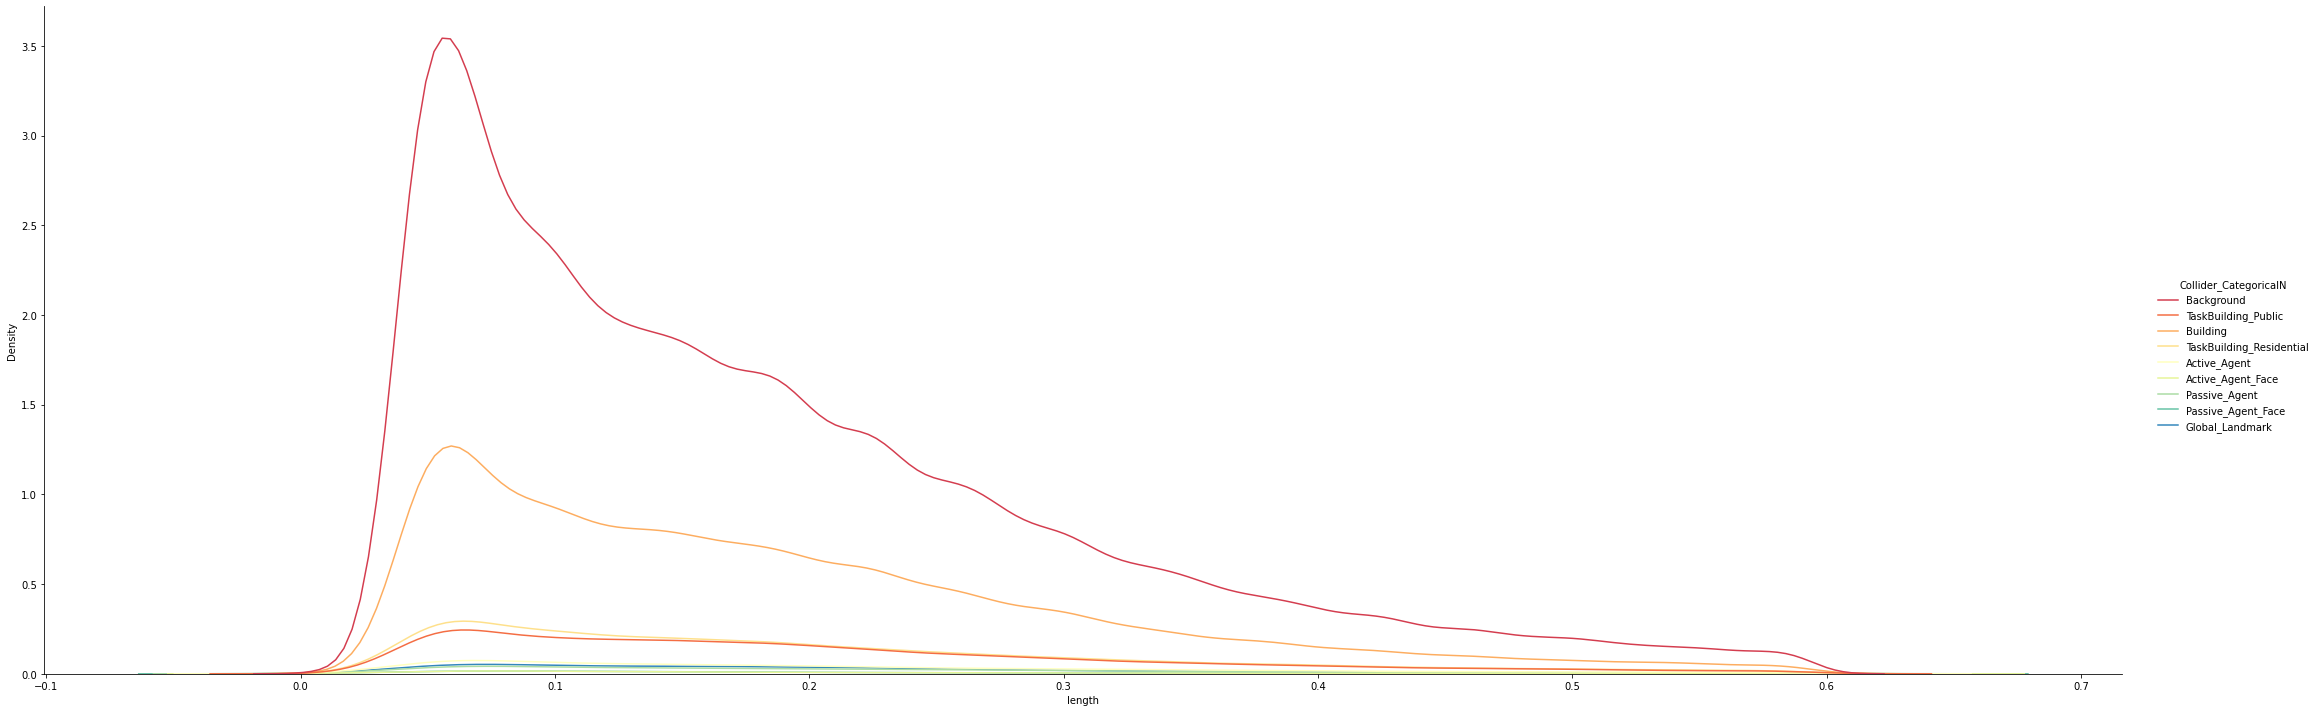

In [10]:
sns.displot(x='length', hue="Collider_CategoricalN",
             data=gaze_no_out, 
            height=10, aspect= 3, kde=True, palette="Spectral",  multiple="stack")

sns.displot(x='length', hue="Collider_CategoricalN",
             data=gaze_no_out, 
            height=10, aspect= 3, kind="kde", palette="Spectral")

In [11]:
# Since the collider names are too detailed, here we create a dictionary with patterns to classify them into our categories of interest
patterns = {'\d{2}_Sa':'Passive_Agent', '\d{2}_Cma':'Active_Agent', 'Building_\d+': 'Building'}
patterns.update(dict.fromkeys(['Castle-TaskBuilding_56', 'Crane_59','HighSilo-TaskBuilding_49', 'Windmill-TaskBuilding_10_1', 'Church-TaskBuilding_16'], 'Global_Landmark'))
patterns.update(dict.fromkeys(['^TaskBuilding_2$','^TaskBuilding_3$', '^TaskBuilding_5$', '^TaskBuilding_8$', '^TaskBuilding_9$', '^TaskBuilding_11$', '^TaskBuilding_13$', '^TaskBuilding_14$', '^TaskBuilding_20$', 
                               '^TaskBuilding_21$', '^TaskBuilding_23$','^TaskBuilding_27$', '^TaskBuilding_29$', '^TaskBuilding_32$', '^TaskBuilding_34$',  '^TaskBuilding_38$', '^TaskBuilding_41$', '^TaskBuilding_42$', 
                               '^TaskBuilding_44$', '^TaskBuilding_45$', '^TaskBuilding_47$', '^TaskBuilding_50$', '^TaskBuilding_51$', '^TaskBuilding_52$', 'BasketballCourt_58', 'Construction_57', 
                               '^Graffity_02$', '^Graffity_03$', '^Graffity_05$', '^Graffity_08$', '^Graffity_09$', '^Graffity_11$', '^Graffity_13$', '^Graffity_14$', '^Graffity_20$', 
                               '^Graffity_21$', '^Graffity_23$', '^Graffity_27$', '^Graffity_29$', '^Graffity_32$', '^Graffity_34$', '^Graffity_38$', '^Graffity_41$', '^Graffity_42$', 
                               '^Graffity_44$', '^Graffity_45$', '^Graffity_47$',  '^Graffity_50$', '^Graffity_51$', '^Graffity_52$'], 'TaskBuilding_Public'))

patterns.update(dict.fromkeys(['^TaskBuilding_1$','^TaskBuilding_4$', '^TaskBuilding_6$', '^TaskBuilding_7$', '^TaskBuilding_12$', '^TaskBuilding_15$', '^TaskBuilding_17$', '^TaskBuilding_18$', '^TaskBuilding_19$', 
                               '^TaskBuilding_22$', '^TaskBuilding_24$','^TaskBuilding_25$', '^TaskBuilding_26$', '^TaskBuilding_28$', '^TaskBuilding_30$',  '^TaskBuilding_31$', '^TaskBuilding_33$', '^TaskBuilding_35$', 
                               '^TaskBuilding_36$', '^TaskBuilding_37$', '^TaskBuilding_39$', '^TaskBuilding_40$', '^TaskBuilding_43$', '^TaskBuilding_48$', '^TaskBuilding_54$','^TaskBuilding_55$',
                               '^Graffity_01$','^Graffity_04$', '^Graffity_06$', '^Graffity_07$', '^Graffity_12$', '^Graffity_15$', '^Graffity_17$', '^Graffity_18$', '^Graffity_19$', '^Graffity_22$', 
                               '^Graffity_24$','^Graffity_25$', '^Graffity_26$', '^Graffity_28$', '^Graffity_30$',  '^Graffity_31$', '^Graffity_33$', '^Graffity_35$', '^Graffity_36$', '^Graffity_37$', '^Graffity_39$', 
                               '^Graffity_40$', '^Graffity_43$', '^Graffity_48$', '^Graffity_54$', '^Graffity_55$' ], 'TaskBuilding_Residential'))
default_val = 'Background'

In [12]:
gaze_no_out["Collider_CategoricalN"] =  gaze_no_out['names'].apply(lambda x: next((val for key, val in patterns.items() if re.match(key, x)), default_val))
#string_to_add = "_Face"
# Define the condition and the string to add
#Mask_1f = ((data_frame_gaze_no_out_ONLY_TEST['Collider_CategoricalN'] == "Active_Agent") & (data_frame_gaze_no_out_ONLY_TEST['Face_Hits'] == "Face")) | ((data_frame_gaze_no_out_ONLY_TEST['Collider_CategoricalN'] == "Passive_Agent") & (data_frame_gaze_no_out_ONLY_TEST['Face_Hits'] == "Face"))
#data_frame_gaze_no_out_ONLY_TEST.loc[Mask_1f, 'Collider_CategoricalN'] = data_frame_gaze_no_out_ONLY_TEST.loc[Mask_1f, 'Collider_CategoricalN'] + string_to_add

In [13]:
# Keep only the gazes that happened on the categories of interest
data_frame_gaze_no_out_ONLY_TEST = gaze_no_out[(gaze_no_out.Collider_CategoricalN != "Background") & (gaze_no_out.Collider_CategoricalN != "Building")].copy()

In [14]:
data_frame_gaze_no_out_ONLY_TEST.Collider_CategoricalN.value_counts(normalize=True)

TaskBuilding_Residential    0.371022
TaskBuilding_Public         0.335450
Active_Agent                0.127760
Passive_Agent               0.087107
Global_Landmark             0.078660
Name: Collider_CategoricalN, dtype: float64

In [19]:
data_frame_gaze_no_out_ONLY_TEST.head()

,Unnamed: 0,level_0,index,SubjectID,Session,SessionSubsection,timeStampDataPointEnd,combinedGazeValidityBitmask,eyePositionCombinedWorld.x,eyePositionCombinedWorld.y,...,corrected_vel,events,length,distance,avg_dist,names,Collider_CategoricalN,Median_Standard_Duration,gaze_mad_z,Outlier_Gaze_Length
70,70,70,70,1031,1,1,1.668436e+09,3,-59.048164,2.419450,...,NaN,-2.0,0.171120,130.993693,130.973733,TaskBuilding_27,TaskBuilding_Public,0.125027,0.111002,Stays
217,217,217,217,1031,1,1,1.668436e+09,3,-59.069908,2.435466,...,15.848451,-2.0,0.088288,9.926199,9.926104,TaskBuilding_35,TaskBuilding_Residential,0.125027,0.551508,Stays
228,228,228,228,1031,1,1,1.668436e+09,3,-59.072449,2.433517,...,19.255171,-2.0,0.077872,12.326112,12.320977,TaskBuilding_35,TaskBuilding_Residential,0.125027,0.634820,Stays
246,246,246,246,1031,1,1,1.668436e+09,3,-59.089291,2.427562,...,6.811582,-2.0,0.310001,7.234847,7.232347,23_Cma,Active_Agent,0.125027,1.221807,Stays
267,267,267,267,1031,1,1,1.668436e+09,3,-59.123661,2.431819,...,0.000000,-2.0,0.311487,12.349276,12.375113,Graffity_35,TaskBuilding_Residential,0.125027,1.233697,Stays


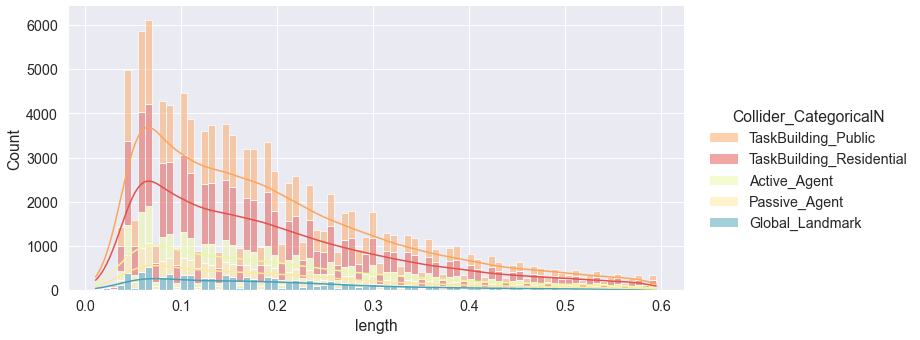

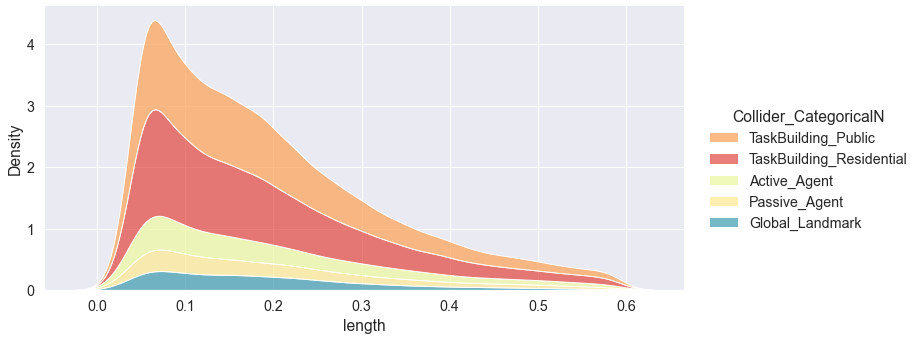

In [93]:
my_Categories = {'TaskBuilding_Residential': '#e2514a', 'Passive_Agent':'#fee999', 'TaskBuilding_Public': '#fca55d',
       'Global_Landmark':'#47a0b3', 'Active_Agent':'#80ed9980ed99'}
sns.displot(x='length', hue="Collider_CategoricalN",
             data=data_frame_gaze_no_out_ONLY_TEST, 
            height=5, aspect= 2, kde=True, palette=my_Categories,  multiple="stack")

sns.displot(x='length', hue="Collider_CategoricalN",
             data=data_frame_gaze_no_out_ONLY_TEST, 
            height=5, aspect= 2, kind="kde", palette=my_Categories, multiple="stack")

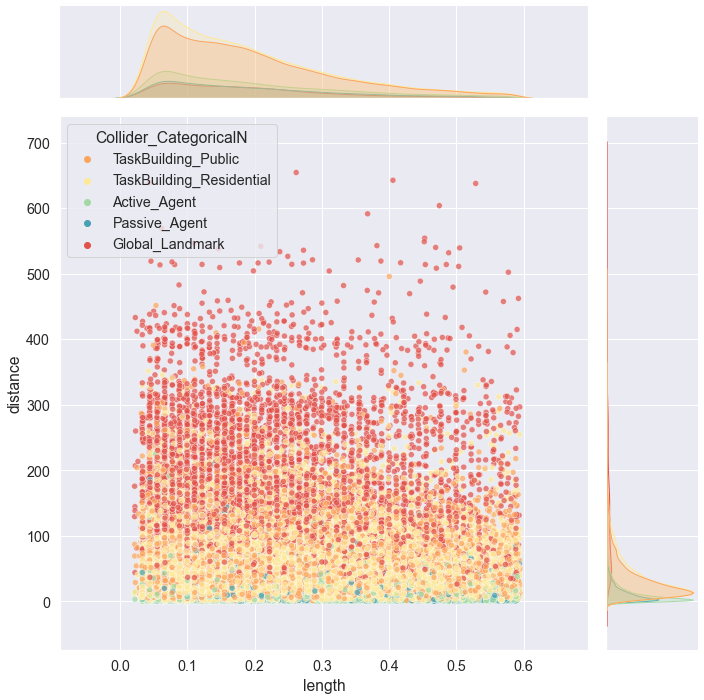

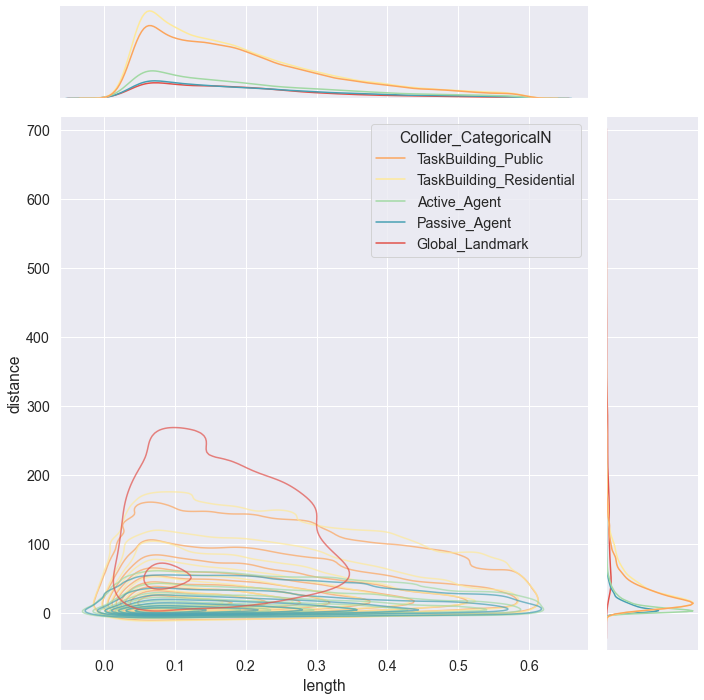

In [117]:
sns.jointplot(data=data_frame_gaze_no_out_ONLY_TEST, y="distance", x="length", hue="Collider_CategoricalN",  height=10, alpha=0.7, palette=my_categories)
sns.jointplot(data=data_frame_gaze_no_out_ONLY_TEST, y="distance", x="length", hue="Collider_CategoricalN",  height=10, alpha=0.7, palette=my_categories,  kind="kde")

In [25]:
# Create a Dictionary that identifies agent, graffity and house into this three categories
patterns2 = {'\d{2}_Sa':'Agent', '\d{2}_Cma':'Agent', '^TaskBuilding_': 'Building', 'BasketballCourt_58': 'Building', '^Graffity':'Graffity'}
patterns2.update(dict.fromkeys(['Castle-TaskBuilding_56', 'Crane_59','HighSilo-TaskBuilding_49', 'Windmill-TaskBuilding_10_1', 'Church-TaskBuilding_16'], 'Global_Landmark'))

In [26]:
data_frame_gaze_no_out_ONLY_TEST['Hit_Object_Category'] = data_frame_gaze_no_out_ONLY_TEST['names'].apply(lambda x: next((val for key, val in patterns2.items() if re.match(key, x)), np.nan))    

In [27]:
data_frame_gaze_no_out_ONLY_TEST = data_frame_gaze_no_out_ONLY_TEST.loc[:, ~data_frame_gaze_no_out_ONLY_TEST.columns.str.contains('^Unnamed')]
data_frame_gaze_no_out_ONLY_TEST.head()

,level_0,index,SubjectID,Session,SessionSubsection,timeStampDataPointEnd,combinedGazeValidityBitmask,eyePositionCombinedWorld.x,eyePositionCombinedWorld.y,eyePositionCombinedWorld.z,...,events,length,distance,avg_dist,names,Collider_CategoricalN,Median_Standard_Duration,gaze_mad_z,Outlier_Gaze_Length,Hit_Object_Category
70,70,70,1031,1,1,1.668436e+09,3,-59.048164,2.419450,34.760757,...,-2.0,0.171120,130.993693,130.973733,TaskBuilding_27,TaskBuilding_Public,0.125027,0.111002,Stays,Building
217,217,217,1031,1,1,1.668436e+09,3,-59.069908,2.435466,34.760433,...,-2.0,0.088288,9.926199,9.926104,TaskBuilding_35,TaskBuilding_Residential,0.125027,0.551508,Stays,Building
228,228,228,1031,1,1,1.668436e+09,3,-59.072449,2.433517,34.757622,...,-2.0,0.077872,12.326112,12.320977,TaskBuilding_35,TaskBuilding_Residential,0.125027,0.634820,Stays,Building
246,246,246,1031,1,1,1.668436e+09,3,-59.089291,2.427562,34.763134,...,-2.0,0.310001,7.234847,7.232347,23_Cma,Active_Agent,0.125027,1.221807,Stays,Agent
267,267,267,1031,1,1,1.668436e+09,3,-59.123661,2.431819,34.757259,...,-2.0,0.311487,12.349276,12.375113,Graffity_35,TaskBuilding_Residential,0.125027,1.233697,Stays,Graffity


### Recode to count the graffity as the house hit 

In [28]:
# Map graffity into the name of the building that it's in front of 
Graffity_mapping = {'Graffity_14':'TaskBuilding_14', 
                  'Graffity_41': 'TaskBuilding_41',
                  'Graffity_02': 'TaskBuilding_2', 
                  'Graffity_47': 'TaskBuilding_47',
                  'Graffity_20': 'TaskBuilding_20',
                  'Graffity_09': 'TaskBuilding_9',
                  'Graffity_50': 'TaskBuilding_50',
                  'Graffity_45': 'TaskBuilding_45',
                  'Graffity_08': 'TaskBuilding_8',
                  'Graffity_27': 'TaskBuilding_27',
                  'Graffity_51': 'TaskBuilding_51',
                  'Graffity_03': 'TaskBuilding_3',
                  'Graffity_11': 'TaskBuilding_11',
                  'Graffity_42': 'TaskBuilding_42',
                  'Graffity_23': 'TaskBuilding_23',
                  'Graffity_52': 'TaskBuilding_52',
                  'Graffity_38': 'TaskBuilding_38',
                  'Graffity_34': 'TaskBuilding_34',
                  'Graffity_05': 'TaskBuilding_5',
                  'Graffity_29': 'TaskBuilding_29',
                  'Graffity_32': 'TaskBuilding_32',
                  'Graffity_13': 'TaskBuilding_13',
                  'Graffity_44': 'TaskBuilding_44',
                  'Graffity_21': 'TaskBuilding_21',
                  'Graffity_04': 'TaskBuilding_4',
                  'Graffity_01': 'TaskBuilding_1',
                  'Graffity_06': 'TaskBuilding_6',
                  'Graffity_07': 'TaskBuilding_7',  
                  'Graffity_17': 'TaskBuilding_17', 
                  'Graffity_15': 'TaskBuilding_15',
                  'Graffity_12': 'TaskBuilding_12',
                  'Graffity_18': 'TaskBuilding_18',
                  'Graffity_19': 'TaskBuilding_19',
                  'Graffity_22': 'TaskBuilding_22',
                  'Graffity_24': 'TaskBuilding_24',
                  'Graffity_25': 'TaskBuilding_25',
                  'Graffity_26': 'TaskBuilding_26',
                  'Graffity_28': 'TaskBuilding_28',
                  'Graffity_30': 'TaskBuilding_30',
                  'Graffity_31': 'TaskBuilding_31',
                  'Graffity_33': 'TaskBuilding_33',
                  'Graffity_35': 'TaskBuilding_35',
                  'Graffity_36': 'TaskBuilding_36',
                  'Graffity_37': 'TaskBuilding_37',
                  'Graffity_39': 'TaskBuilding_39',
                  'Graffity_40': 'TaskBuilding_40',
                  'Graffity_43': 'TaskBuilding_43',
                  'Graffity_48': 'TaskBuilding_48',
                  'Graffity_54': 'TaskBuilding_54',
                  'Graffity_55': 'TaskBuilding_55'
             }

In [30]:
# Here we recode the literal expression on dictionary Graffity_mapping
data_frame_gaze_no_out_ONLY_TEST.loc[:, 'recoded'] = data_frame_gaze_no_out_ONLY_TEST.loc[:,'names']
data_frame_gaze_no_out_ONLY_TEST['recoded'].replace(Graffity_mapping, inplace=True)

In [31]:
data_frame_gaze_no_out_ONLY_TEST["Collider_CategoricalN"] =  data_frame_gaze_no_out_ONLY_TEST['recoded'].apply(lambda x: next((val for key, val in patterns.items() if re.match(key, x)), default_val))

## Cummulative sum calculation

In [32]:
data_frame_gaze_no_out_ONLY_TEST["cumsum_length"] = data_frame_gaze_no_out_ONLY_TEST.groupby(["SubjectID", "recoded", "Collider_CategoricalN"])['length'].cumsum()

In [33]:
data_frame_gaze_no_out_ONLY_TEST.head(20)

,level_0,index,SubjectID,Session,SessionSubsection,timeStampDataPointEnd,combinedGazeValidityBitmask,eyePositionCombinedWorld.x,eyePositionCombinedWorld.y,eyePositionCombinedWorld.z,...,distance,avg_dist,names,Collider_CategoricalN,Median_Standard_Duration,gaze_mad_z,Outlier_Gaze_Length,Hit_Object_Category,recoded,cumsum_length
70,70,70,1031,1,1,1.668436e+09,3,-59.048164,2.419450,34.760757,...,130.993693,130.973733,TaskBuilding_27,TaskBuilding_Public,0.125027,0.111002,Stays,Building,TaskBuilding_27,0.171120
217,217,217,1031,1,1,1.668436e+09,3,-59.069908,2.435466,34.760433,...,9.926199,9.926104,TaskBuilding_35,TaskBuilding_Residential,0.125027,0.551508,Stays,Building,TaskBuilding_35,0.088288
228,228,228,1031,1,1,1.668436e+09,3,-59.072449,2.433517,34.757622,...,12.326112,12.320977,TaskBuilding_35,TaskBuilding_Residential,0.125027,0.634820,Stays,Building,TaskBuilding_35,0.166160
246,246,246,1031,1,1,1.668436e+09,3,-59.089291,2.427562,34.763134,...,7.234847,7.232347,23_Cma,Active_Agent,0.125027,1.221807,Stays,Agent,23_Cma,0.310001
267,267,267,1031,1,1,1.668436e+09,3,-59.123661,2.431819,34.757259,...,12.349276,12.375113,Graffity_35,TaskBuilding_Residential,0.125027,1.233697,Stays,Graffity,TaskBuilding_35,0.477648
320,320,320,1031,1,1,1.668436e+09,3,-59.018215,2.443910,34.757027,...,12.394278,12.390313,Graffity_35,TaskBuilding_Residential,0.125027,0.249853,Stays,Graffity,TaskBuilding_35,0.666128
331,331,331,1031,1,1,1.668436e+09,3,-59.008221,2.444259,34.758366,...,12.808676,12.806624,Graffity_35,TaskBuilding_Residential,0.125027,0.547549,Stays,Graffity,TaskBuilding_35,0.754911
352,352,352,1031,1,1,1.668436e+09,3,-59.017628,2.442195,34.763046,...,12.765611,12.761636,Graffity_35,TaskBuilding_Residential,0.125027,1.495534,Stays,Graffity,TaskBuilding_35,1.099135
557,557,557,1031,1,1,1.668436e+09,3,-59.027905,2.416220,34.782959,...,10.894607,10.894529,TaskBuilding_35,TaskBuilding_Residential,0.125027,0.872853,Stays,Building,TaskBuilding_35,1.147246
759,759,759,1031,1,1,1.668436e+09,3,-54.562382,2.427841,38.617199,...,123.782945,124.168623,TaskBuilding_27,TaskBuilding_Public,0.125027,0.269689,Stays,Building,TaskBuilding_27,0.362080


In [34]:
data_frame_gaze_no_out_ONLY_TEST[["length", "recoded", "cumsum_length"]] 

,length,recoded,cumsum_length
70,0.171120,TaskBuilding_27,0.171120
217,0.088288,TaskBuilding_35,0.088288
228,0.077872,TaskBuilding_35,0.166160
246,0.310001,23_Cma,0.310001
267,0.311487,TaskBuilding_35,0.477648
...,...,...,...
14211902,0.420612,Windmill-TaskBuilding_10_1,30.904855
14212752,0.110609,Windmill-TaskBuilding_10_1,31.015463
14212755,0.044640,Windmill-TaskBuilding_10_1,31.060104
14212766,0.100689,Windmill-TaskBuilding_10_1,31.160792


In [35]:
data_frame_gaze_no_out_ONLY_TEST.cumsum_length.describe()

count    114950.000000
mean          8.186959
std           7.762038
min           0.012399
25%           2.545770
50%           6.025876
75%          11.397074
max          61.142519
Name: cumsum_length, dtype: float64

In [36]:
Dwelling_time = pd.DataFrame(data_frame_gaze_no_out_ONLY_TEST.groupby(["SubjectID","recoded","Collider_CategoricalN"])["cumsum_length"].max())
Dwelling_time.reset_index(inplace=True)
Count = pd.DataFrame(data_frame_gaze_no_out_ONLY_TEST.groupby(["SubjectID","recoded","Collider_CategoricalN"])["cumsum_length"].count())
Count.reset_index(inplace=True)
Fixations = Dwelling_time.merge(Count, on=["SubjectID", "recoded","Collider_CategoricalN"])
Fixations.rename({"cumsum_length_x": "Dwelling_Time", "cumsum_length_y":"Fixation_Count"}, axis=1, inplace=True)

In [37]:
Fixations

,SubjectID,recoded,Collider_CategoricalN,Dwelling_Time,Fixation_Count
0,1031,01_Cma,Active_Agent,7.795758,39
1,1031,02_Cma,Active_Agent,0.620509,6
2,1031,03_Cma,Active_Agent,5.063690,26
3,1031,04_Cma,Active_Agent,1.016814,3
4,1031,05_Cma,Active_Agent,4.783982,21
...,...,...,...,...,...
2748,9627,TaskBuilding_6,TaskBuilding_Residential,8.768292,51
2749,9627,TaskBuilding_7,TaskBuilding_Residential,6.325496,26
2750,9627,TaskBuilding_8,TaskBuilding_Public,10.597064,59
2751,9627,TaskBuilding_9,TaskBuilding_Public,9.779672,48


In [38]:
Fixations.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2753 entries, 0 to 2752
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   SubjectID              2753 non-null   int64  
 1   recoded                2753 non-null   object 
 2   Collider_CategoricalN  2753 non-null   object 
 3   Dwelling_Time          2753 non-null   float64
 4   Fixation_Count         2753 non-null   int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 129.0+ KB


### Sanity check: Make sure that the cummulative sum equals the same as the raw length 

In [39]:
Fixation_sum = pd.DataFrame(Fixations.groupby(["SubjectID"])["Dwelling_Time"].sum())
Fixation_sum.reset_index(inplace=True)
Fixation_sum.loc[:, "Minutes"] = (Fixation_sum.Dwelling_Time)/60
Fixation_sum.loc[:, "Hours"] = (Fixation_sum.Minutes)/60
Fixation_sum

,SubjectID,Dwelling_Time,Minutes,Hours
0,1031,1005.179596,16.752993,0.279217
1,1268,963.920926,16.065349,0.267756
2,1574,871.204033,14.520067,0.242001
3,1843,717.187108,11.953118,0.199219
4,2069,799.570702,13.326178,0.222103
5,3193,1049.050746,17.484179,0.291403
6,3540,420.721649,7.012027,0.116867
7,4580,752.052089,12.534201,0.208903
8,4598,1055.083677,17.584728,0.293079
9,4847,804.771146,13.412852,0.223548


In [40]:
Complete_Sum = pd.DataFrame(data_frame_gaze_no_out_ONLY_TEST.groupby(["SubjectID"])["length"].sum())
Complete_Sum.reset_index(inplace=True)
Complete_Sum.loc[:, "Minutes"] = (Complete_Sum.length)/60
Complete_Sum.loc[:, "Hours"] = (Complete_Sum.Minutes)/60
Complete_Sum

,SubjectID,length,Minutes,Hours
0,1031,1005.179596,16.752993,0.279217
1,1268,963.920926,16.065349,0.267756
2,1574,871.204033,14.520067,0.242001
3,1843,717.187108,11.953118,0.199219
4,2069,799.570702,13.326178,0.222103
5,3193,1049.050746,17.484179,0.291403
6,3540,420.721649,7.012027,0.116867
7,4580,752.052089,12.534201,0.208903
8,4598,1055.083677,17.584728,0.293079
9,4847,804.771146,13.412852,0.223548


In [41]:
TaskBuildings_GL = Fixations.loc[(Fixations.recoded.str.match('^TaskBuilding_')) | (Fixations.Collider_CategoricalN == 'Global_Landmark') ]
order_buildings = pd.DataFrame(TaskBuildings_GL.groupby("recoded")["Dwelling_Time"].median().sort_values(ascending=False))
Agents = Fixations.loc[Fixations.Collider_CategoricalN.str.contains("Agent")]
order_agents = pd.DataFrame(Agents.groupby("recoded")["Dwelling_Time"].median().sort_values(ascending=False))

In [38]:
Agents

,SubjectID,recoded,Collider_CategoricalN,Dwelling_Time,Fixation_Count
0,1031,01_Cma,Active_Agent,7.795758,39
1,1031,02_Cma,Active_Agent,0.620509,6
2,1031,03_Cma,Active_Agent,5.063690,26
3,1031,04_Cma,Active_Agent,1.016814,3
4,1031,05_Cma,Active_Agent,4.783982,21
...,...,...,...,...,...
2691,9627,52_Sa,Passive_Agent,0.978113,4
2692,9627,53_Sa,Passive_Agent,0.552046,2
2693,9627,54_Sa,Passive_Agent,0.661171,3
2694,9627,55_Sa,Passive_Agent,1.131379,7


### Visualization of Dweling-Times (AKA. cummulative sums) 

In [45]:
Fixations[['Dwelling_Time', 'Fixation_Count']].corr().style.background_gradient(cmap="Spectral")

,Dwelling_Time,Fixation_Count
Dwelling_Time,1.000000,0.985588
Fixation_Count,0.985588,1.000000


In [95]:
Fixation_count = pd.DataFrame(Fixations.groupby("Collider_CategoricalN")["Fixation_Count"].mean().sort_values(ascending=False))
Fixation_count

,Fixation_Count
Collider_CategoricalN,
Global_Landmark,72.336000
TaskBuilding_Residential,65.613846
TaskBuilding_Public,59.414484
Active_Agent,21.886736
Passive_Agent,15.217325


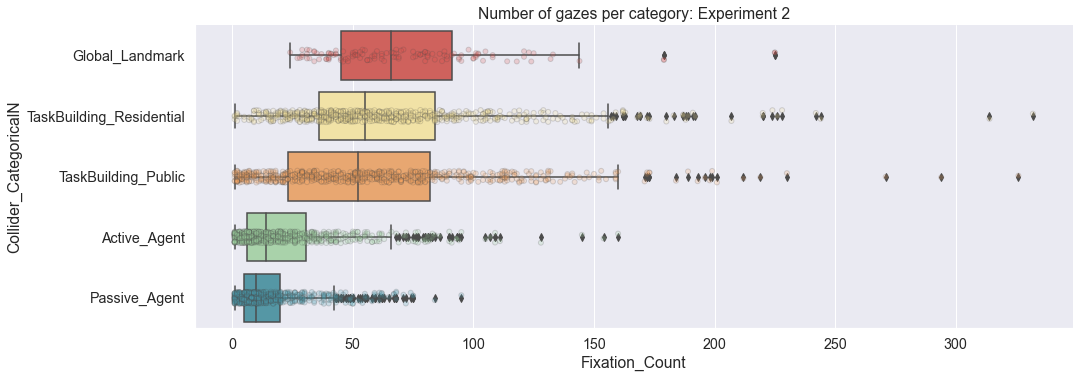

In [99]:
sns.catplot(y="Collider_CategoricalN", x="Fixation_Count", order= Fixation_count.index.values, data=Fixations, \
            height=5, aspect=3, kind='box', palette=my_categories).set(title="Number of gazes per category: Experiment 2")
ax = sns.stripplot(y="Collider_CategoricalN", x="Fixation_Count",  order= Fixation_count.index.values, data=Fixations, \
                   alpha=0.2, dodge=True,linewidth=1,edgecolor='gray', palette=my_categories)

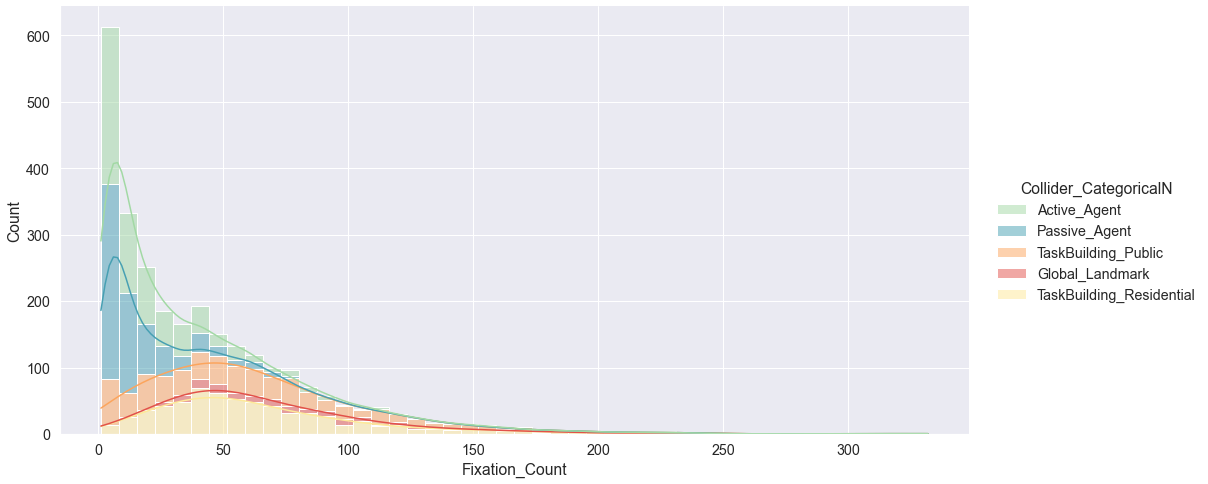

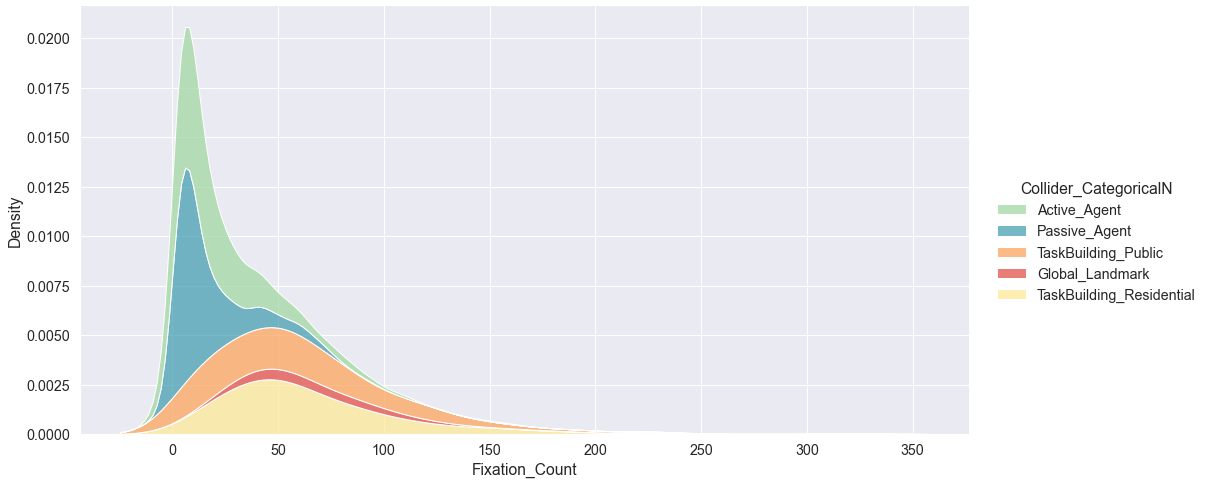

In [100]:
sns.displot(x='Fixation_Count', hue="Collider_CategoricalN",
             data=Fixations, 
            height=7, aspect= 2, kde=True, palette=my_categories, multiple="stack")

sns.displot(x='Fixation_Count', hue="Collider_CategoricalN",
             data=Fixations, 
            height=7, aspect= 2, kind="kde", palette=my_categories, multiple="stack")

In [102]:
Fixation_Dwelling_Time = pd.DataFrame(Fixations.groupby("Collider_CategoricalN")["Dwelling_Time"].mean().sort_values(ascending=False))
Fixation_Dwelling_Time

,Dwelling_Time
Collider_CategoricalN,
Global_Landmark,14.321897
TaskBuilding_Residential,12.635018
TaskBuilding_Public,11.690757
Active_Agent,4.452775
Passive_Agent,3.144906


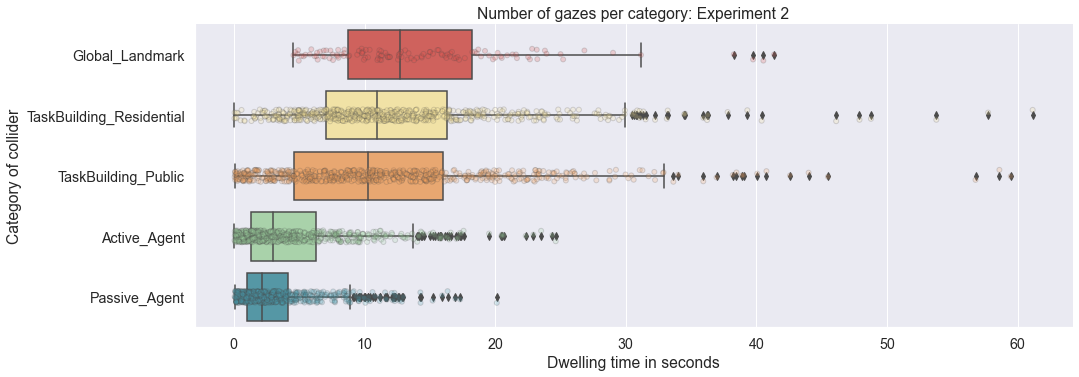

In [108]:
sns.catplot(y="Collider_CategoricalN", x="Dwelling_Time", order= Fixation_Dwelling_Time.index.values, data=Fixations, \
            height=5, aspect=3, kind='box', palette=my_categories)
ax = sns.stripplot(y="Collider_CategoricalN", x="Dwelling_Time",  order= Fixation_Dwelling_Time.index.values, data=Fixations, \
                   alpha=0.2, dodge=True,linewidth=1,edgecolor='gray', palette=my_categories).set(title="Number of gazes per category: Experiment 2", xlabel="Dwelling time in seconds", ylabel= "Category of collider")

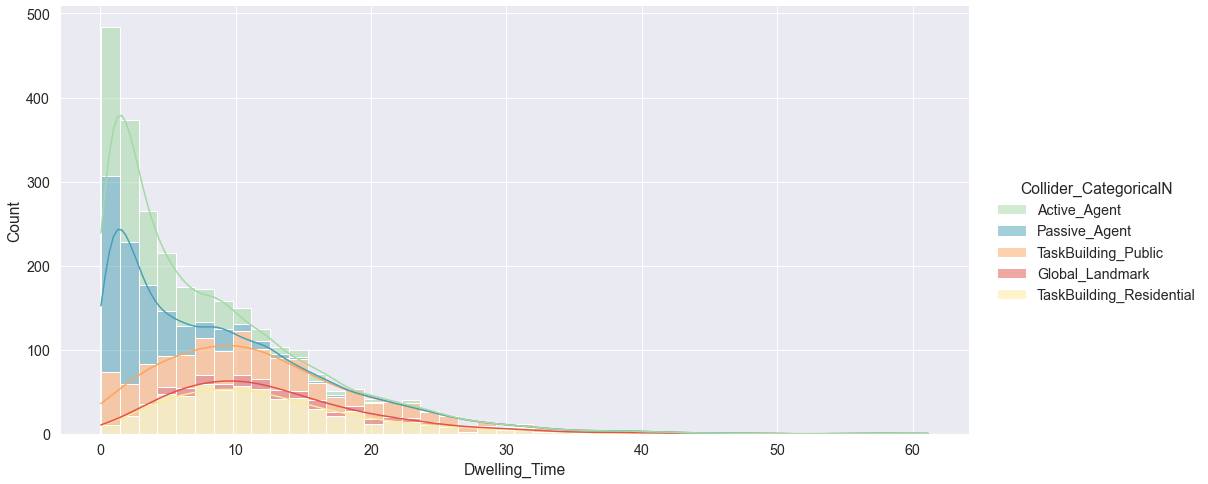

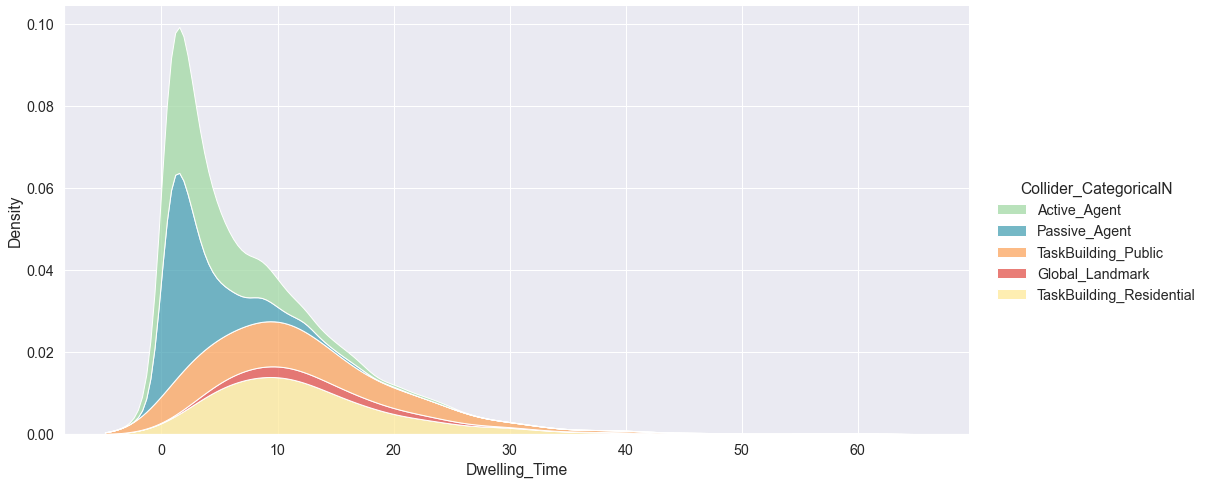

In [109]:
sns.displot(x='Dwelling_Time', hue="Collider_CategoricalN",
             data=Fixations, 
            height=7, aspect= 2, kde=True, palette=my_categories, multiple="stack")

sns.displot(x='Dwelling_Time', hue="Collider_CategoricalN",
             data=Fixations, 
            height=7, aspect= 2, kind="kde", palette=my_categories, multiple="stack")

<AxesSubplot: xlabel='Fixation_Count', ylabel='Dwelling_Time'>

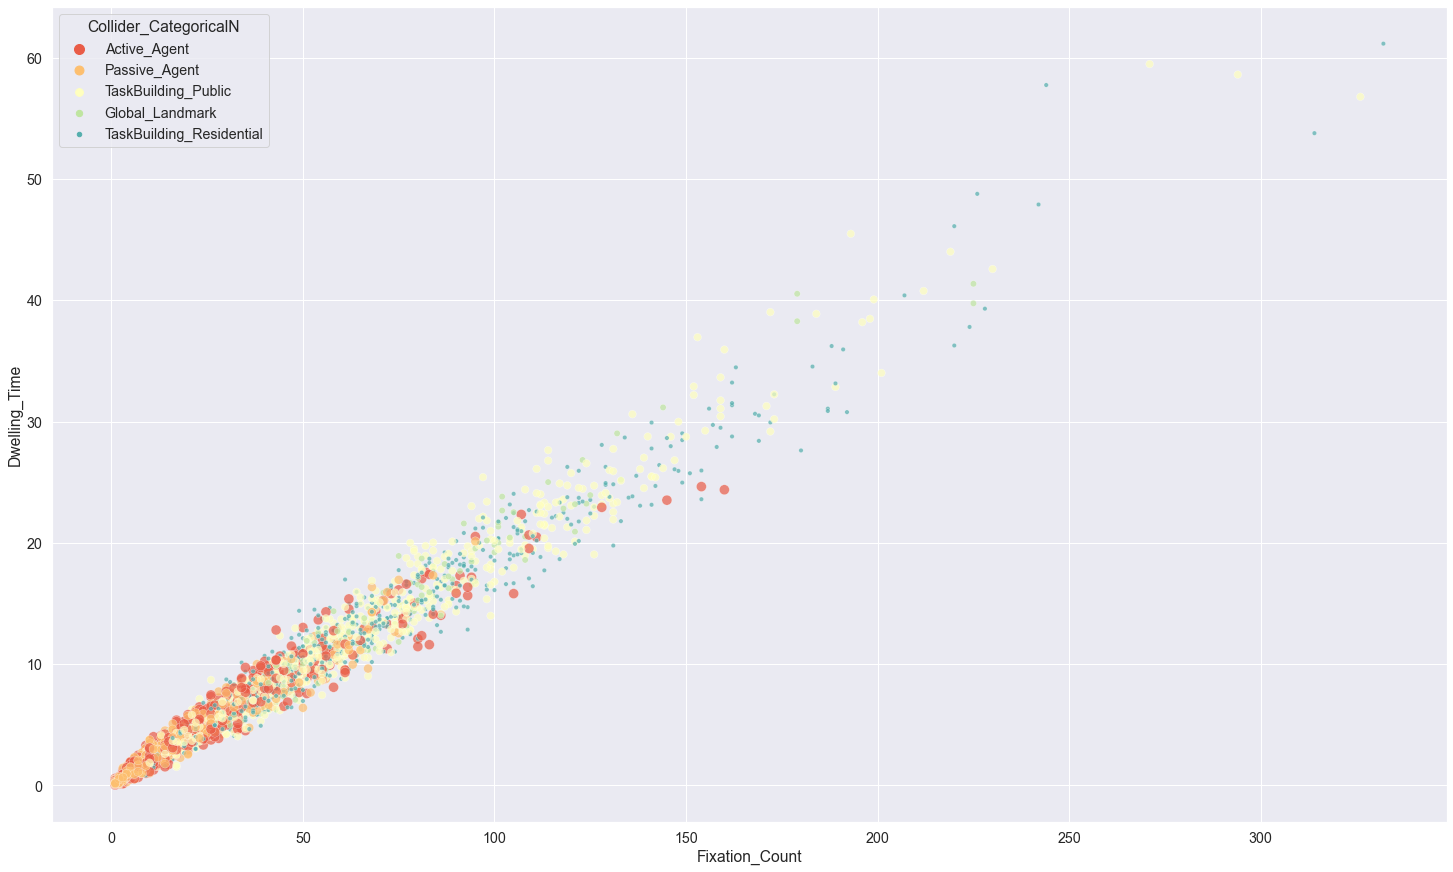

In [48]:
plt.figure(figsize=(25,15))
sns.set(font_scale = 1.3)
sns.scatterplot(x='Fixation_Count', y='Dwelling_Time', hue="Collider_CategoricalN",
                size="Collider_CategoricalN", sizes=(20,100), legend="full", data=Fixations, alpha=0.7, palette="Spectral")

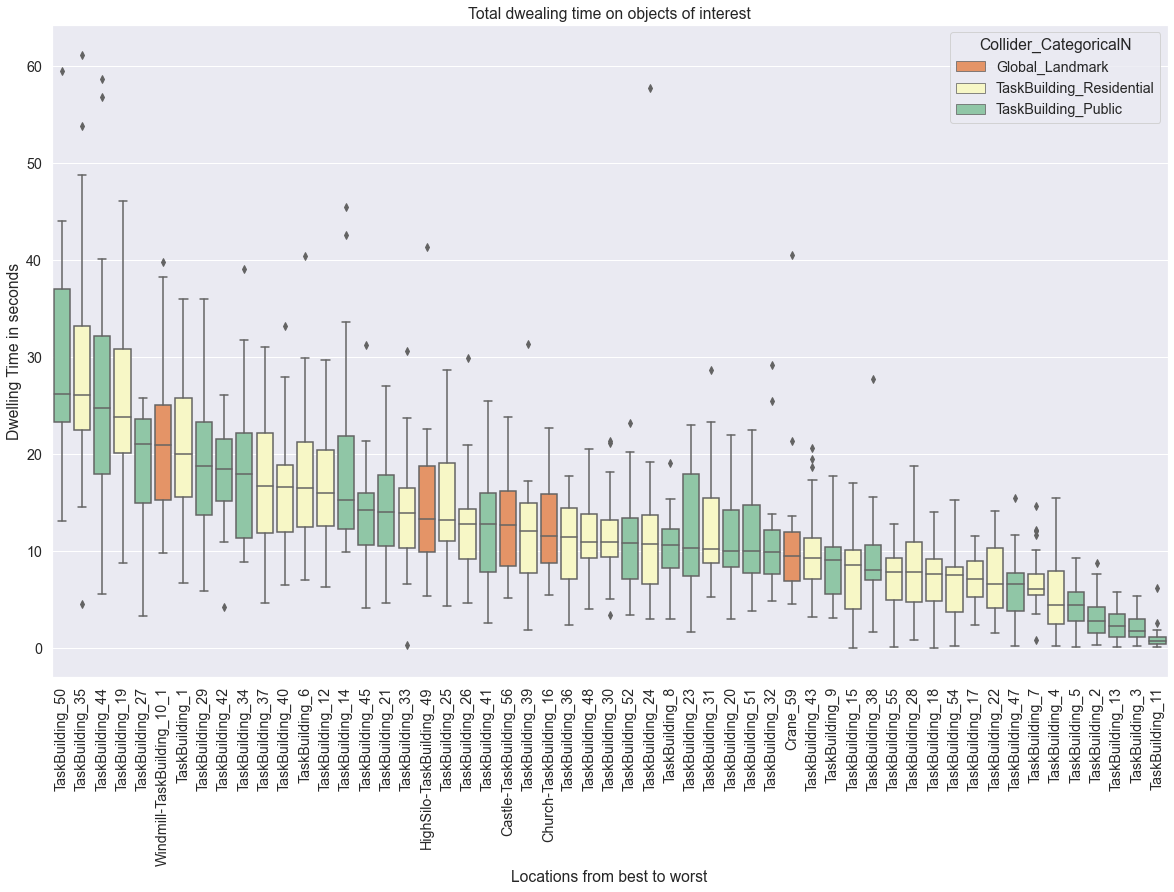

In [64]:
plt.figure(figsize=(20,12))
a = sns.boxplot(x='recoded', y='Dwelling_Time', dodge=False, hue="Collider_CategoricalN", order= order_buildings.index.values, data=TaskBuildings_GL, palette="Spectral")
plt.title('Total dwealing time on objects of interest')
plt.xlabel('Locations from best to worst')
plt.ylabel('Dwelling Time in seconds')
plt.xticks(rotation=90);

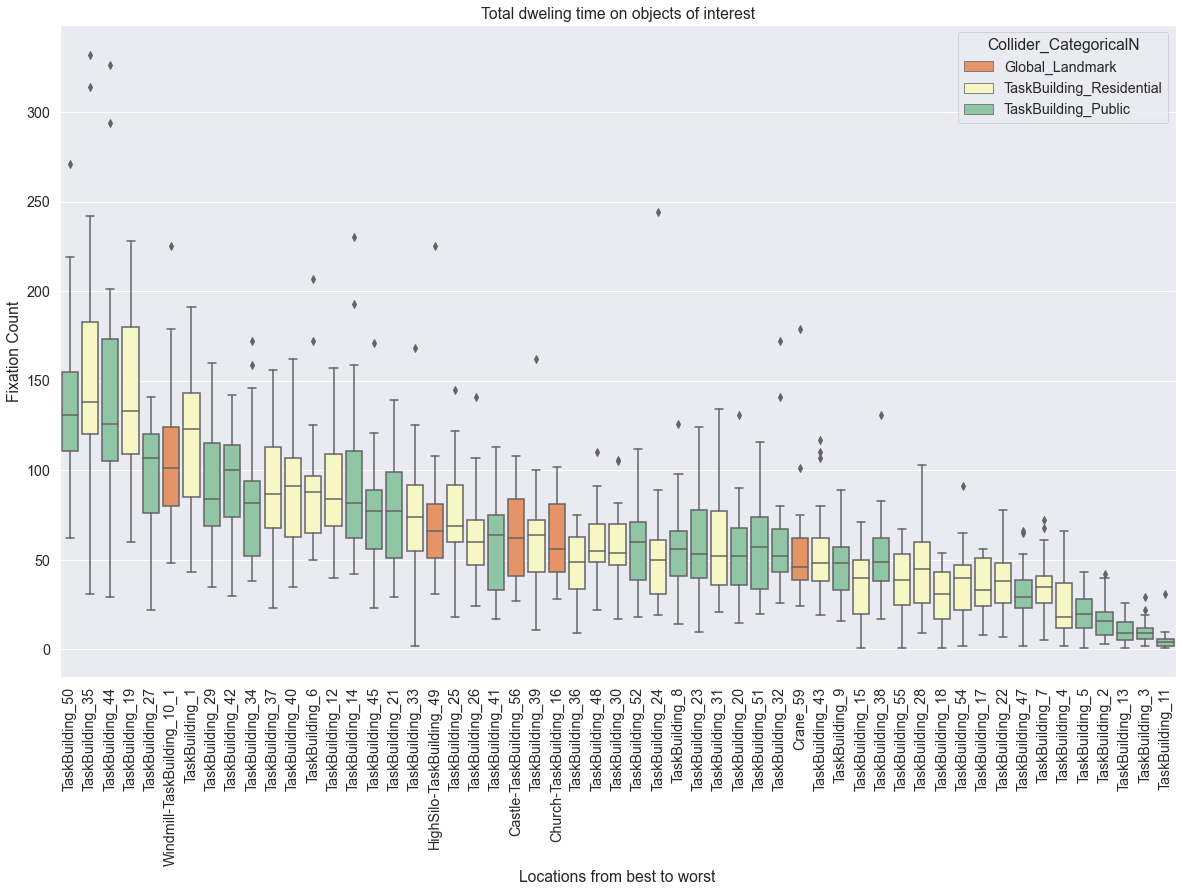

In [65]:
plt.figure(figsize=(20,12))
a = sns.boxplot(x='recoded', y='Fixation_Count', dodge=False, hue="Collider_CategoricalN", order= order_buildings.index.values, data=TaskBuildings_GL, palette="Spectral")
plt.title('Total dweling time on objects of interest')
plt.xlabel('Locations from best to worst')
plt.ylabel('Fixation Count')
plt.xticks(rotation=90);

In [110]:
my_categories_agent = {'Active_Agent': '#a2d9a4',
                'Passive_Agent': '#47a0b3'}

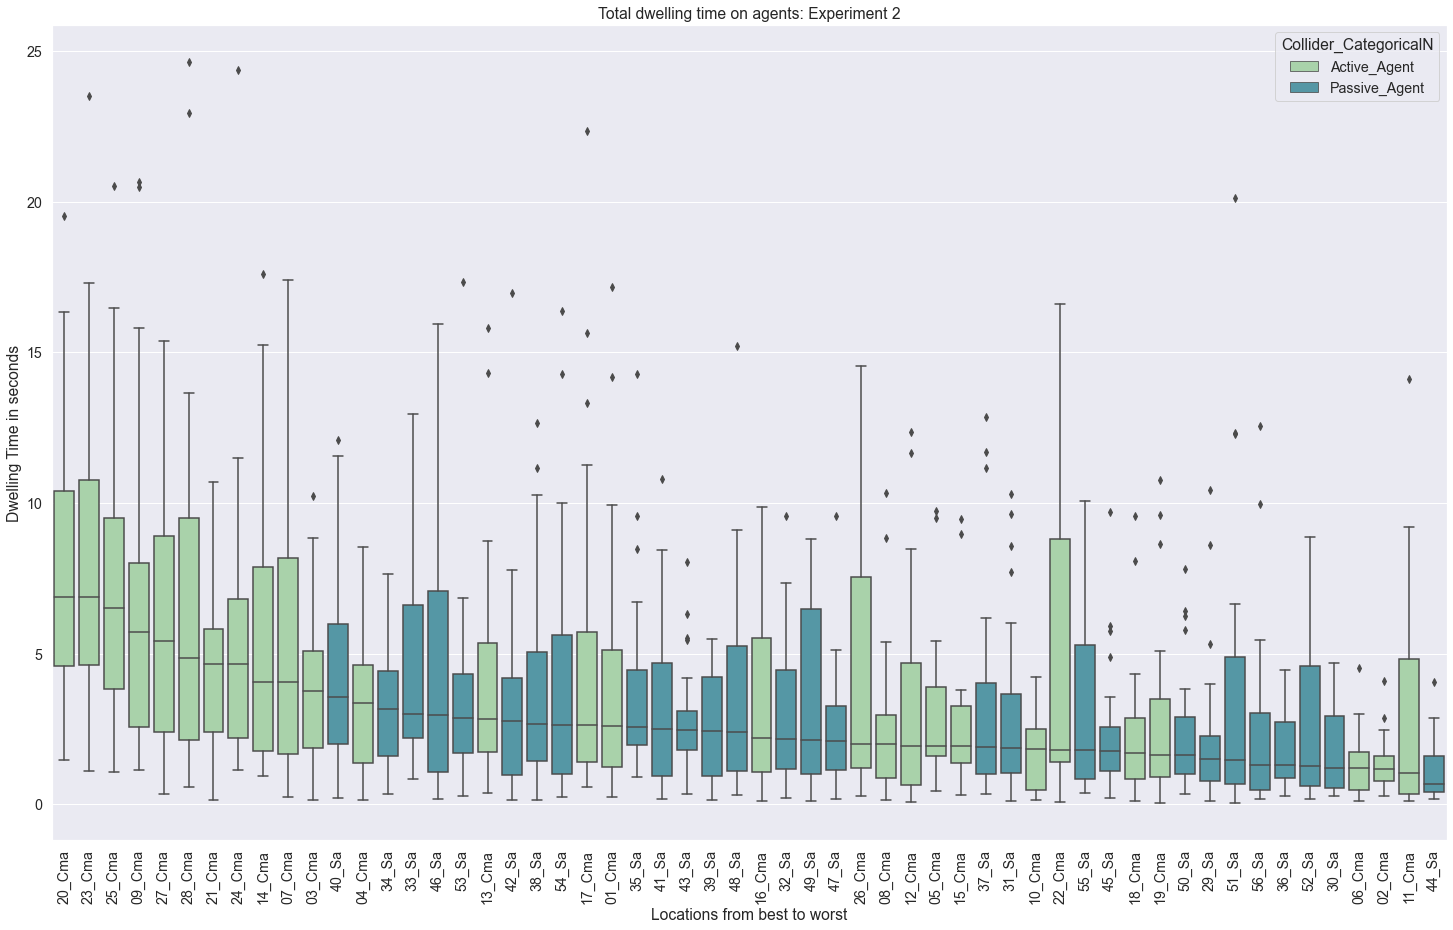

In [115]:
plt.figure(figsize=(25,15))
a = sns.boxplot(x='recoded', y='Dwelling_Time', dodge=False, hue="Collider_CategoricalN", order= order_agents.index.values, data=Agents, palette=my_categories_agent)
plt.title('Total dwelling time on agents: Experiment 2')
plt.xlabel('Locations from best to worst')
plt.ylabel('Dwelling Time in seconds')
plt.xticks(rotation=90);

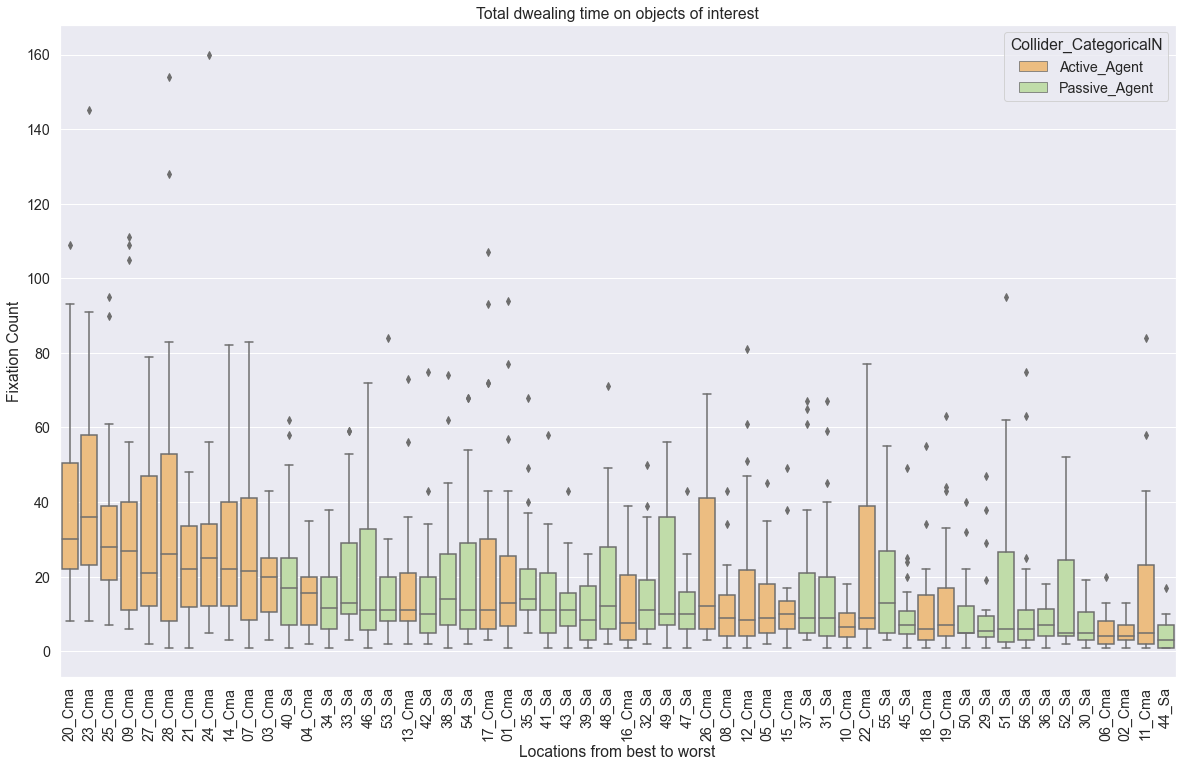

In [68]:
plt.figure(figsize=(20,12))
a = sns.boxplot(x='recoded', y='Fixation_Count', dodge=False, hue="Collider_CategoricalN", order= order_agents.index.values, data=Agents, palette="Spectral")
plt.title('Total dwealing time on objects of interest')
plt.xlabel('Locations from best to worst')
plt.ylabel('Fixation Count')
plt.xticks(rotation=90);

## Preparation for the merging of behavioral data with Dwelling times 

In [56]:
# Create a dictionary that identifies: Agent, Building, and graffity with one ID
patterns1 = {'^01_Cma$':1}
patterns1.update(dict.fromkeys(['^TaskBuilding_14$','^Graffity_14$'], 1))
patterns1.update(dict.fromkeys(['^02_Cma$','^TaskBuilding_41$','^Graffity_41$'], 2))
patterns1.update(dict.fromkeys(['^03_Cma$','^TaskBuilding_2$', '^Graffity_02$'], 3))
patterns1.update(dict.fromkeys(['^04_Cma$','^TaskBuilding_47$','^Graffity_47$'], 4))
patterns1.update(dict.fromkeys(['^05_Cma$','^Construction_57$'], 5))
patterns1.update(dict.fromkeys(['^06_Cma$','^TaskBuilding_20$','^Graffity_20$'], 6))
patterns1.update(dict.fromkeys(['^07_Cma$','^TaskBuilding_9$','^Graffity_09$'], 7))
patterns1.update(dict.fromkeys(['^08_Cma$','^TaskBuilding_50$','^Graffity_50$'], 8))
patterns1.update(dict.fromkeys(['^09_Cma$','^TaskBuilding_45$','^Graffity_45$'], 9))
patterns1.update(dict.fromkeys(['^10_Cma$','^TaskBuilding_8$','^Graffity_08$'], 10))
patterns1.update(dict.fromkeys(['^11_Cma$','^TaskBuilding_27$','^Graffity_27$'], 11))
patterns1.update(dict.fromkeys(['^12_Cma$','^TaskBuilding_51$','^Graffity_51$'], 12))
patterns1.update(dict.fromkeys(['^13_Cma$','^TaskBuilding_3$','^Graffity_03$'], 13))
patterns1.update(dict.fromkeys(['^14_Cma$','^TaskBuilding_11$','^Graffity_11$'], 14))
patterns1.update(dict.fromkeys(['^15_Cma$','^TaskBuilding_42$','^Graffity_42$'], 15))
patterns1.update(dict.fromkeys(['^16_Cma$','^TaskBuilding_23$','^Graffity_23$'], 16))
patterns1.update(dict.fromkeys(['^17_Cma$','^TaskBuilding_52$','^Graffity_52$'], 17))
patterns1.update(dict.fromkeys(['^18_Cma$','^TaskBuilding_38$','^Graffity_38$'], 18))
patterns1.update(dict.fromkeys(['^19_Cma$','^TaskBuilding_34$','^Graffity_34$'], 19))
patterns1.update(dict.fromkeys(['^20_Cma$','^BasketballCourt_58$'], 20))
patterns1.update(dict.fromkeys(['^21_Cma$','^TaskBuilding_5$','^Graffity_05$'], 21))
patterns1.update(dict.fromkeys(['^22_Cma$','^TaskBuilding_29$','^Graffity_29$'], 22))
patterns1.update(dict.fromkeys(['^23_Cma$','^TaskBuilding_32$','^Graffity_32$'], 23))
patterns1.update(dict.fromkeys(['^24_Cma$','^TaskBuilding_13$','^Graffity_13$'], 24))
patterns1.update(dict.fromkeys(['^25_Cma$','^TaskBuilding_44$','^Graffity_44$'], 25))
patterns1.update(dict.fromkeys(['^26_Cma$','^TaskBuilding_21$','^Graffity_21$'], 26))
patterns1.update(dict.fromkeys(['^27_Cma$','^Crane_59$', 'Castle-TaskBuilding_56'], 27))
patterns1.update(dict.fromkeys(['^28_Cma$','^Church-TaskBuilding_16'], 28))
patterns1.update(dict.fromkeys(['^29_Sa$','^TaskBuilding_4$','^Graffity_04$'], 29))
patterns1.update(dict.fromkeys(['^30_Sa$','^TaskBuilding_1$','^Graffity_01$'], 30))
patterns1.update(dict.fromkeys(['^31_Sa$','^TaskBuilding_6$','^Graffity_06$'], 31))
patterns1.update(dict.fromkeys(['^32_Sa$','^TaskBuilding_7$','^Graffity_07$'], 32))
patterns1.update(dict.fromkeys(['^33_Sa$','^TaskBuilding_17$','^Graffity_17$'], 33))
patterns1.update(dict.fromkeys(['^34_Sa$','^TaskBuilding_15$','^Graffity_15$'], 34))
patterns1.update(dict.fromkeys(['^35_Sa$','^TaskBuilding_12$','^Graffity_12$'], 35))
patterns1.update(dict.fromkeys(['^36_Sa$','^TaskBuilding_18$','^Graffity_18$'], 36))
patterns1.update(dict.fromkeys(['^37_Sa$','^TaskBuilding_19$','^Graffity_19$'], 37))
patterns1.update(dict.fromkeys(['^38_Sa$','^TaskBuilding_22$','^Graffity_22$'], 38))
patterns1.update(dict.fromkeys(['^39_Sa$','^TaskBuilding_24$','^Graffity_24$'], 39))
patterns1.update(dict.fromkeys(['^40_Sa','^TaskBuilding_25$','^Graffity_25$'], 40))
patterns1.update(dict.fromkeys(['^41_Sa','^TaskBuilding_26$','^Graffity_26$'], 41))
patterns1.update(dict.fromkeys(['^42_Sa','^TaskBuilding_28$','^Graffity_28$'], 42))
patterns1.update(dict.fromkeys(['^43_Sa','^TaskBuilding_30$','^Graffity_30$'], 43))
patterns1.update(dict.fromkeys(['^44_Sa','^TaskBuilding_31$','^Graffity_31$'], 44))
patterns1.update(dict.fromkeys(['^45_Sa','^TaskBuilding_33$','^Graffity_33$'], 45))
patterns1.update(dict.fromkeys(['^46_Sa','^TaskBuilding_35$','^Graffity_35$'], 46))
patterns1.update(dict.fromkeys(['^47_Sa','^TaskBuilding_36$','^Graffity_36$'], 47))
patterns1.update(dict.fromkeys(['^48_Sa','^TaskBuilding_37$','^Graffity_37$'], 48))
patterns1.update(dict.fromkeys(['^49_Sa','^TaskBuilding_39$','^Graffity_39$'], 49))
patterns1.update(dict.fromkeys(['^50_Sa','^TaskBuilding_40$','^Graffity_40$'], 50))
patterns1.update(dict.fromkeys(['^51_Sa','^TaskBuilding_43$','^Graffity_43$'], 51))
patterns1.update(dict.fromkeys(['^52_Sa','^TaskBuilding_48$','^Graffity_48$'], 52))
patterns1.update(dict.fromkeys(['^53_Sa','^TaskBuilding_54$','^Graffity_54$'], 53))
patterns1.update(dict.fromkeys(['^54_Sa','^TaskBuilding_55$','^Graffity_55$'], 54))
patterns1.update(dict.fromkeys(['^55_Sa','^Windmill-TaskBuilding_10_1'], 55))
patterns1.update(dict.fromkeys(['^56_Sa','^HighSilo-TaskBuilding_49'], 56))
default_val = np.nan

In [75]:
Fixations['avatar_ID'] = Fixations['recoded'].apply(lambda x: next((val for key, val in patterns1.items() if re.match(key, x)), default_val))    

In [76]:
Fixations['Category'] = np.where(Fixations.Collider_CategoricalN.str.contains("Agent"), "Agent_Gaze", "Building_Gaze")

In [77]:
Agent_Fixation = Fixations[Fixations.Category == "Agent_Gaze"]
Building_Fixation = Fixations[Fixations.Category == "Building_Gaze"]
Building_Fixation = Building_Fixation[Building_Fixation.recoded != 'Crane_59'].copy()

In [78]:
Fixations

,SubjectID,recoded,Collider_CategoricalN,Dwelling_Time,Fixation_Count,avatar_ID,Category
0,1031,01_Cma,Active_Agent,7.795758,39,1,Agent_Gaze
1,1031,02_Cma,Active_Agent,0.620509,6,2,Agent_Gaze
2,1031,03_Cma,Active_Agent,5.063690,26,3,Agent_Gaze
3,1031,04_Cma,Active_Agent,1.016814,3,4,Agent_Gaze
4,1031,05_Cma,Active_Agent,4.783982,21,5,Agent_Gaze
...,...,...,...,...,...,...,...
2748,9627,TaskBuilding_6,TaskBuilding_Residential,8.768292,51,31,Building_Gaze
2749,9627,TaskBuilding_7,TaskBuilding_Residential,6.325496,26,32,Building_Gaze
2750,9627,TaskBuilding_8,TaskBuilding_Public,10.597064,59,10,Building_Gaze
2751,9627,TaskBuilding_9,TaskBuilding_Public,9.779672,48,7,Building_Gaze


In [79]:
Agent_wide_Fixations = Agent_Fixation.pivot(index=["SubjectID", 'avatar_ID'], columns='Category', values=["Dwelling_Time", "Fixation_Count"])
Building_wide_Fixations = Building_Fixation.pivot(index=["SubjectID", 'avatar_ID'], columns='Category', values=["Dwelling_Time", "Fixation_Count"])
Agent_wide_Fixations.reset_index(inplace=True)
Building_wide_Fixations.reset_index(inplace=True)

In [80]:
Agent_wide_Fixations.columns = ['_'.join(col) for col in Agent_wide_Fixations.columns]
Building_wide_Fixations.columns = ['_'.join(col) for col in Building_wide_Fixations.columns]
Agent_wide_Fixations

,SubjectID_,avatar_ID_,Dwelling_Time_Agent_Gaze,Fixation_Count_Agent_Gaze
0,1031,1,7.795758,39.0
1,1031,2,0.620509,6.0
2,1031,3,5.063690,26.0
3,1031,4,1.016814,3.0
4,1031,5,4.783982,21.0
...,...,...,...,...
1324,9627,52,0.978113,4.0
1325,9627,53,0.552046,2.0
1326,9627,54,0.661171,3.0
1327,9627,55,1.131379,7.0


In [81]:
Agent_wide_Fixations.rename({"SubjectID_":"SubjectID", "avatar_ID_":"avatar_ID"}, inplace=True, axis=1)
Building_wide_Fixations.rename({"SubjectID_":"SubjectID", "avatar_ID_":"avatar_ID"}, inplace=True, axis=1)

In [82]:
wide_Fixations = Building_wide_Fixations.merge(Agent_wide_Fixations, on=["SubjectID", "avatar_ID"])
wide_Fixations

,SubjectID,avatar_ID,Dwelling_Time_Building_Gaze,Fixation_Count_Building_Gaze,Dwelling_Time_Agent_Gaze,Fixation_Count_Agent_Gaze
0,1031,1,12.285170,68.0,7.795758,39.0
1,1031,2,10.532623,67.0,0.620509,6.0
2,1031,3,2.396216,16.0,5.063690,26.0
3,1031,4,2.918567,16.0,1.016814,3.0
4,1031,5,2.419004,16.0,4.783982,21.0
...,...,...,...,...,...,...
1323,9627,52,10.959626,52.0,0.978113,4.0
1324,9627,53,13.954972,62.0,0.552046,2.0
1325,9627,54,8.339261,39.0,0.661171,3.0
1326,9627,55,31.160792,144.0,1.131379,7.0


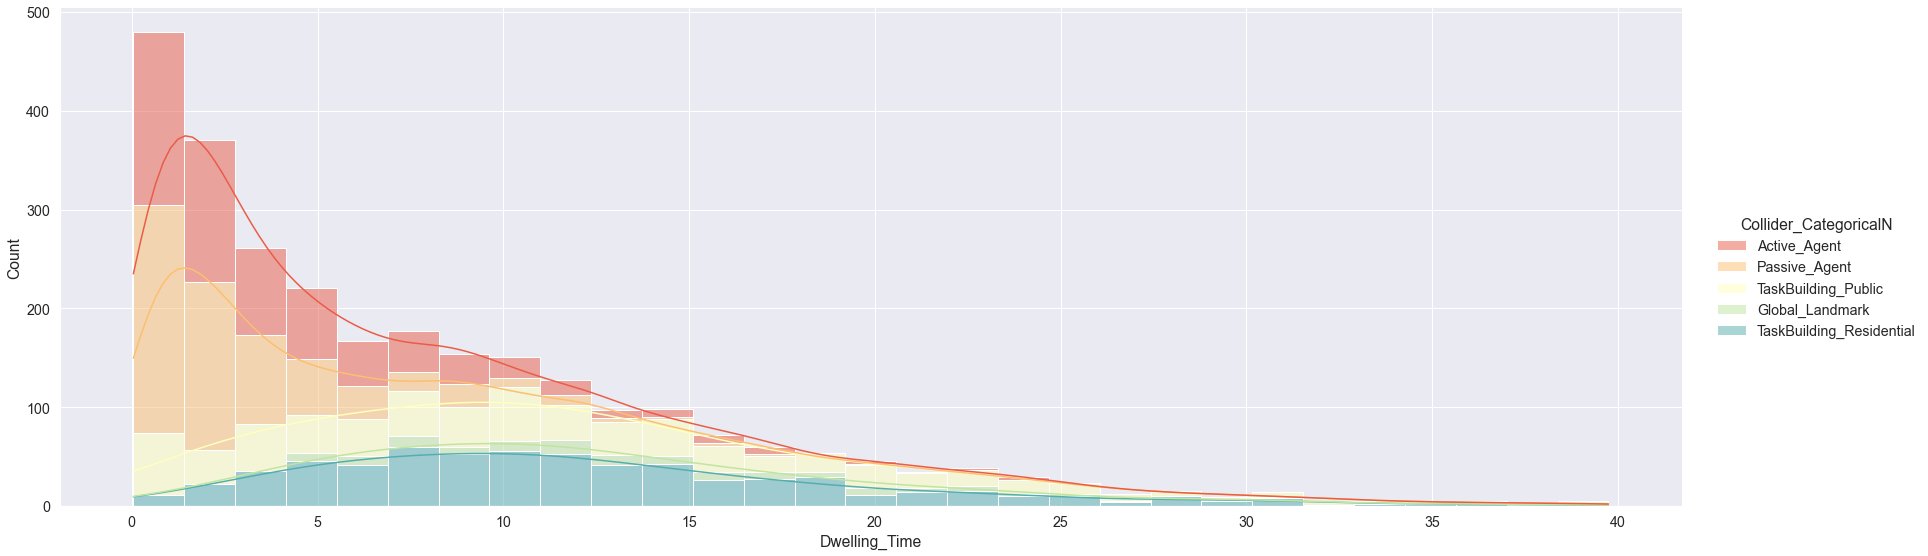

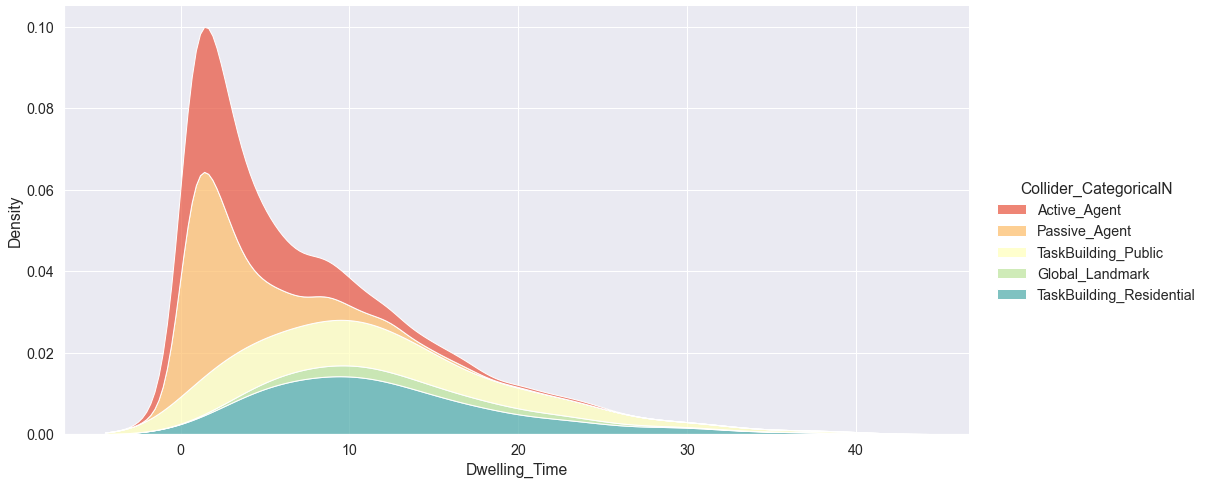

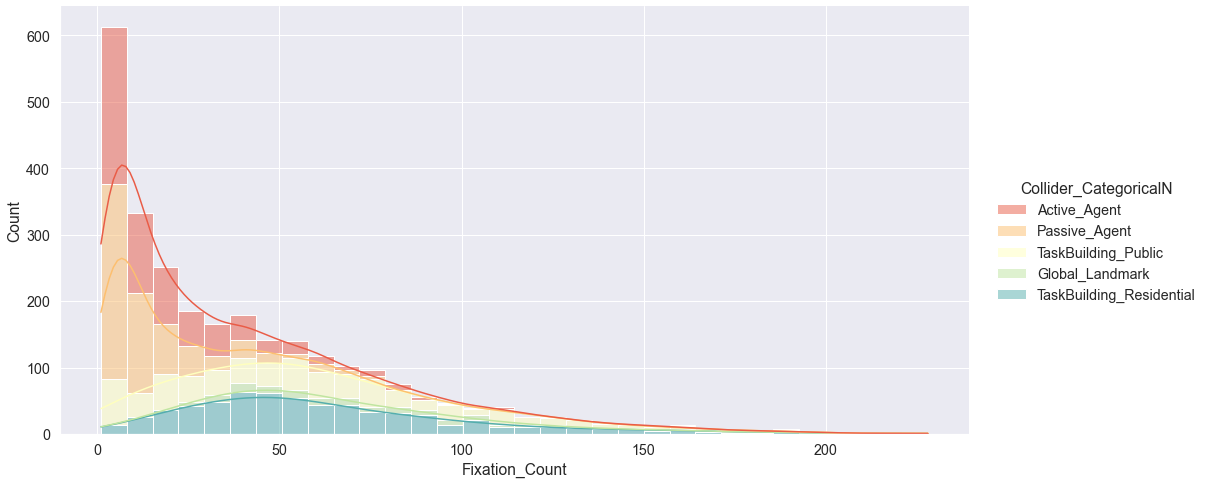

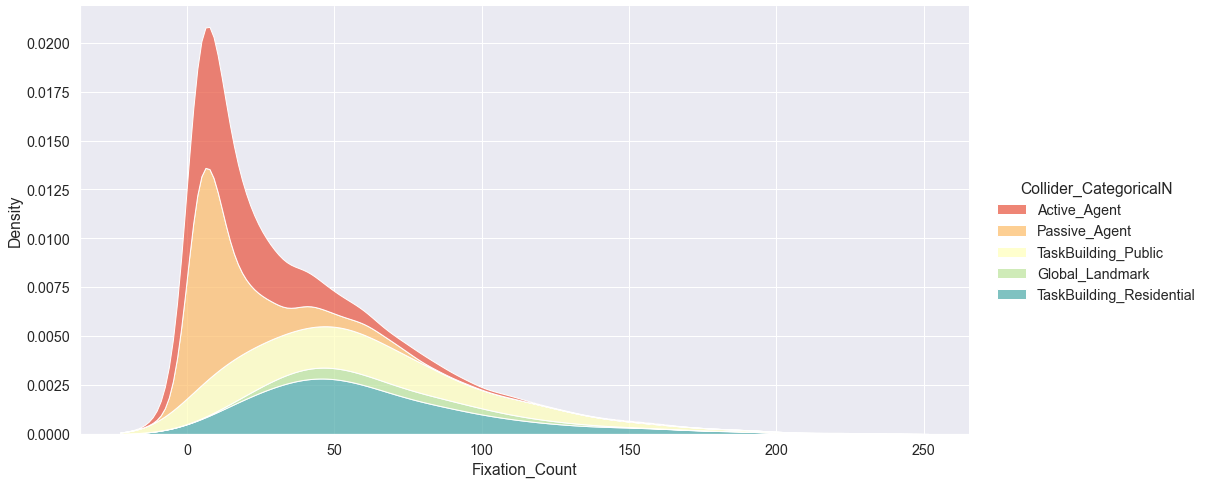

In [62]:
sns.displot(x='Dwelling_Time', hue="Collider_CategoricalN",
             data=Fixations[Fixations.Dwelling_Time < 40], 
            height=7, aspect= 2, kde=True, palette="Spectral",  multiple="stack")

sns.displot(x='Dwelling_Time', hue="Collider_CategoricalN",
             data=Fixations[Fixations.Dwelling_Time < 40], 
            height=7, aspect= 2, kind="kde", palette="Spectral",  multiple="stack")

sns.displot(x='Fixation_Count', hue="Collider_CategoricalN",
             data=Fixations[Fixations.Dwelling_Time < 40], 
            height=7, aspect= 2, kde=True, palette="Spectral",  multiple="stack")

sns.displot(x='Fixation_Count', hue="Collider_CategoricalN",
             data=Fixations[Fixations.Dwelling_Time < 40], 
            height=7, aspect= 2, kind="kde", palette="Spectral",  multiple="stack")

In [70]:
Behavioral = pd.read_csv("/Volumes/TwoTeras/1_Experiment_2/Pointing_Task/Results/BuildingPointingSummary_exp2.csv")

In [71]:
Behavioral.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5595 entries, 0 to 5594
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     5595 non-null   int64  
 1   ID                             5595 non-null   int64  
 2   AbsolutError                   5595 non-null   float64
 3   SignedAngle-+180               5595 non-null   float64
 4   IQR                            5595 non-null   float64
 5   RT                             5595 non-null   float64
 6   DistanceToParticipant          5595 non-null   float64
 7   PointingTaskStartingLocations  5595 non-null   int64  
 8   TrialNumber                    5595 non-null   int64  
 9   StartPointID                   5595 non-null   int64  
 10  ID_for_StartingPosition        5595 non-null   int64  
 11  avatarID                       5595 non-null   int64  
 12  AvatarPresenceCategory         5595 non-null   o

In [72]:
Behavioral.rename({"ID":"SubjectID", "avatarID":"avatar_ID"}, axis=1, inplace=True)
Behavioral

,Unnamed: 0,SubjectID,AbsolutError,SignedAngle-+180,IQR,RT,DistanceToParticipant,PointingTaskStartingLocations,TrialNumber,StartPointID,ID_for_StartingPosition,avatar_ID,AvatarPresenceCategory,Context,BuildingCategory,ImageName
0,0,1031,53.795348,53.795348,37.943541,25.217632,307.299805,21,1,1,1,33,Omitted,True,meaningful,33_CmANo_20
1,1,1031,49.112601,49.112601,37.943541,26.154576,189.228897,13,27,4,3,33,Omitted,True,meaningful,33_CmANo_20
2,2,1031,30.743297,30.743297,37.943541,5.969860,381.328827,4,144,18,8,33,Omitted,True,meaningful,33_CmANo_20
3,3,1031,151.423249,-151.423249,37.943541,24.303504,258.106903,21,2,1,2,43,Present,False,Not meaningful,43_Sa_55
4,4,1031,26.825266,26.825266,37.943541,27.219497,83.646942,25,45,6,5,43,Omitted,False,Not meaningful,43_SaNo_55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5590,5590,3540,4.922629,-4.922629,77.822989,4.667887,245.611038,12,182,23,6,35,Omitted,True,meaningful,35_CmANo_42
5591,5591,3540,38.229867,-38.229867,77.822989,1.711214,317.307739,8,194,25,2,35,Omitted,True,meaningful,35_CmANo_42
5592,5592,3540,94.416805,-94.416805,77.822989,8.394359,227.438751,24,47,6,7,5,Omitted,True,meaningful,05_CmANoAct_05
5593,5593,3540,34.262253,-34.262253,77.822989,9.918083,252.766769,22,70,9,6,5,Present,True,meaningful,05_CmAAct_05


In [85]:
BehavioralData_Fixations_Wide = Behavioral.merge(wide_Fixations, on=["SubjectID", "avatar_ID"], how="left")
BehavioralData_Fixations_Wide.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5595 entries, 0 to 5594
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     5595 non-null   int64  
 1   SubjectID                      5595 non-null   int64  
 2   AbsolutError                   5595 non-null   float64
 3   SignedAngle-+180               5595 non-null   float64
 4   IQR                            5595 non-null   float64
 5   RT                             5595 non-null   float64
 6   DistanceToParticipant          5595 non-null   float64
 7   PointingTaskStartingLocations  5595 non-null   int64  
 8   TrialNumber                    5595 non-null   int64  
 9   StartPointID                   5595 non-null   int64  
 10  ID_for_StartingPosition        5595 non-null   int64  
 11  avatar_ID                      5595 non-null   int64  
 12  AvatarPresenceCategory         5595 non-null   o

BehavioralData_Fixations_Wide.head()

In [86]:

BehavioralData_Fixations_Wide["Agent_Action_level"] = np.where(BehavioralData_Fixations_Wide.avatar_ID > 28, "Passive", "Active")

In [87]:
BehavioralData_Fixations_Wide.to_csv("/Volumes/TwoTeras/1_Experiment_2/Eye_Tracking/Pre_processed/Data_Sets/BehavioralData_Fixations_Wide.csv")

In [88]:
BehavioralData_Fixations_Wide[['Dwelling_Time_Agent_Gaze', 'Dwelling_Time_Building_Gaze',
       'Fixation_Count_Agent_Gaze', 'Fixation_Count_Building_Gaze',  'AbsolutError' ]].corr().style.background_gradient(cmap="viridis")

,Dwelling_Time_Agent_Gaze,Dwelling_Time_Building_Gaze,Fixation_Count_Agent_Gaze,Fixation_Count_Building_Gaze,AbsolutError
Dwelling_Time_Agent_Gaze,1.000000,0.021687,0.974978,0.040140,-0.065089
Dwelling_Time_Building_Gaze,0.021687,1.000000,0.024117,0.980419,-0.002915
Fixation_Count_Agent_Gaze,0.974978,0.024117,1.000000,0.045341,-0.067657
Fixation_Count_Building_Gaze,0.040140,0.980419,0.045341,1.000000,-0.001045
AbsolutError,-0.065089,-0.002915,-0.067657,-0.001045,1.000000


In [ ]:
experiment_1 = pd.read_csv("/Volumes/TwoTeras/0_Experiment_1/Eye_Tracking/Pre_processed/Data_Sets/BehavioralData_Fixations_Wide.csv")

In [ ]:
BehavioralData_Fixations_Wide = BehavioralData_Fixations_Wide.loc[:, ~BehavioralData_Fixations_Wide.columns.str.contains('^Unnamed')]
experiment_1 = experiment_1.loc[:, ~experiment_1.columns.str.contains('^Unnamed')]
experiment_1["Experiment"]= 1
BehavioralData_Fixations_Wide["Experiment"] = 2
experiment_1.rename({"meaningfulBuilding": "BuildingCategory"}, axis=1, inplace=True)

In [ ]:
experiment_1.info()

In [ ]:
BehavioralData_Fixations_Wide.info()

In [ ]:
frames = [BehavioralData_Fixations_Wide, experiment_1]
result = pd.concat(frames)
result.info()

In [ ]:
result.to_csv("/Volumes/TwoTeras/2_DataSets_Experiments_1_2/BehavioralData_Fixations_Wide.csv")

In [ ]:
data_frame_gaze_no_out_ONLY_TEST.groupby([ "Hit_Object_Category", "Session"])["length"].agg(['median','count','mean','std','max', 'min'])

In [ ]:
summary_name_stats_fix_length_NS_Agent.to_csv("/Volumes/TwoTeras/0_Experiment_1/Eye_Tracking/Pre_processed/Data_Sets/summary_name_stats_fix_length_NS_Agent.csv")

In [ ]:
summary_name_stats_fix_length_NS = pd.DataFrame(data_frame_gaze_no_out_ONLY_TEST.groupby([ "SubjectID",  "Hit_Object_Category", "Collider_CategoricalN","Session" ])["length"].agg(['count','mean','median','std','max', 'min']))

In [ ]:
data_frame_gaze_no_out_ONLY_TEST.columns

In [ ]:
summary_name_stats_fix_length_NS.reset_index(inplace=True)

In [ ]:
summary_name_stats_fix_length_NS

In [ ]:
summary_name_stats_fix_length_NS_Agent = summary_name_stats_fix_length_NS[summary_name_stats_fix_length_NS.Hit_Object_Category == 'Agent'].copy()
summary_name_stats_fix_length_NS_Agent['Agent_Category'] = summary_name_stats_fix_length_NS_Agent['Collider_CategoricalN'].str.contains('Active')
summary_name_stats_fix_length_NS_Agent.loc[:, 'Agent_Category'] = summary_name_stats_fix_length_NS_Agent['Agent_Category'].replace({True: 'Active', False: 'Passive'})

In [ ]:
summary_name_stats_fix_length_NS_Agent

In [ ]:
summary_name_stats_fix_length.shape

In [ ]:
summary_stats_fix_length = pd.DataFrame(data_frame_gaze_no_out.groupby(["Collider_CategoricalN", "SubjectID", "Session"])["length"].agg(['count','mean','median','std','max', 'min']))
summary_stats_fix_length.reset_index(inplace=True)

In [ ]:
summary_name_stats_fix_length_BIG= pd.DataFrame(data_frame_gaze_no_out_ONLY_TEST.groupby([ "SubjectID", "Hit_Object_Category", "Collider_CategoricalN","Session" ])["length"].agg(['count','mean','median','std','max', 'min']))

In [ ]:
summary_name_stats_fix_length_BIG.reset_index(inplace=True)
summary_name_stats_fix_length_BIG.head(20)

In [ ]:
summary_name_stats_fix_length_BIG.to_csv("/Volumes/TwoTeras/0_Experiment_1/Eye_Tracking/Pre_processed/Data_Sets/Grouped_Gazes.cvs")

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_palette("flare")
sns.catplot(x="Hit_Object_Category", y="median", hue="Session", data=summary_name_stats_fix_length_BIG[(summary_name_stats_fix_length_BIG.Hit_Object_Category == "Agent")], \
            height=5, aspect=3, kind='box').set(title="Median length of gazes per session")
ax = sns.stripplot(x="Hit_Object_Category", y="median", hue="Session", data=summary_name_stats_fix_length_BIG[summary_name_stats_fix_length_BIG.Hit_Object_Category == "Agent"], \
                   alpha=0.5, dodge=True,linewidth=1,edgecolor='gray')
ax.get_legend().remove()
plt.savefig('/Users/tracysanchezpacheco/Desktop/counts.png',  bbox_inches='tight')

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.catplot(x="Hit_Object_Category", y="count", hue="Session", data=summary_name_stats_fix_length_BIG[(summary_name_stats_fix_length_BIG.Hit_Object_Category == "Agent")], \
            height=5, aspect=3, kind='box').set(title="Number of gazes per session")
ax = sns.stripplot(x="Hit_Object_Category", y="count", hue="Session", data=summary_name_stats_fix_length_BIG[summary_name_stats_fix_length_BIG.Hit_Object_Category == "Agent"], \
                   alpha=0.5, dodge=True,linewidth=1,edgecolor='gray')
ax.get_legend().remove()
plt.savefig('/Users/tracysanchezpacheco/Desktop/counts.png',  bbox_inches='tight')

In [ ]:
dy='Hit_Object_Category'; dx='count'; ort='h'; pal = sns.color_palette(); sigma = .2
f, ax = plt.subplots(figsize=(18, 15))

import ptitprince as pt

ax=pt.half_violinplot(x = dx, y = dy, data = summary_name_stats_fix_length_BIG, palette = pal, bw = .2, cut = 0.,
                      scale = 'area', width = .6, inner = None, orient = ort)
ax=sns.stripplot(x = dx, y = dy, data = summary_name_stats_fix_length_BIG, palette = pal, edgecolor = 'white',
                 size = 3, jitter = 1, zorder = 0, orient = ort)
ax=sns.boxplot(x = dx, y = dy, data = summary_name_stats_fix_length_BIG, color = 'black', width = .15, zorder = 10,\
            showcaps = True, boxprops = {'facecolor':'none', 'zorder':10},\
            showfliers=True, whiskerprops = {'linewidth':2, 'zorder':10},\
            saturation = 1, orient = ort) 

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_palette("flare")
sns.catplot(x="Collider_CategoricalN", y="count", hue="Session", data=summary_stats_fix_length[(summary_stats_fix_length.Collider_CategoricalN != "Background")], \
            height=5, aspect=3, kind='box').set(title="Number of gazes per session")
ax = sns.stripplot(x="Collider_CategoricalN", y="count",  hue="Session", data=summary_stats_fix_length[(summary_stats_fix_length.Collider_CategoricalN != "Background")], \
                   alpha=0.5, dodge=True,linewidth=1,edgecolor='gray')
ax.get_legend().remove()
plt.savefig('/Users/tracysanchezpacheco/Desktop/count.png')

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_palette("flare")
sns.catplot(x="Collider_CategoricalN", y="count", hue="Session", data=summary_stats_fix_length[(summary_stats_fix_length.Collider_CategoricalN == "Active_Agent")|(summary_stats_fix_length.Collider_CategoricalN == "Active_Agent_Face")|(summary_stats_fix_length.Collider_CategoricalN == "Passive_Agent")|(summary_stats_fix_length.Collider_CategoricalN == "Passive_Agent_Face")], \
            height=5, aspect=3, kind='box').set(title="Number of gazes per session")
ax = sns.stripplot(x="Collider_CategoricalN", y="count",  hue="Session", data=summary_stats_fix_length[(summary_stats_fix_length.Collider_CategoricalN == "Active_Agent")|(summary_stats_fix_length.Collider_CategoricalN == "Active_Agent_Face")|(summary_stats_fix_length.Collider_CategoricalN == "Passive_Agent")|(summary_stats_fix_length.Collider_CategoricalN == "Passive_Agent_Face")], \
                   alpha=0.5, dodge=True,linewidth=1,edgecolor='gray')
#plt.ylim(top=100)
ax.get_legend().remove()
plt.savefig('/Users/tracysanchezpacheco/Desktop/count_Faces.png',  bbox_inches='tight')

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_palette("flare")
sns.catplot(x="Collider_CategoricalN", y="median", hue="Session", data=summary_stats_fix_length[(summary_stats_fix_length.Collider_CategoricalN == "Active_Agent")|(summary_stats_fix_length.Collider_CategoricalN == "Active_Agent_Face")|(summary_stats_fix_length.Collider_CategoricalN == "Passive_Agent")|(summary_stats_fix_length.Collider_CategoricalN == "Passive_Agent_Face")], \
            height=6, aspect=3, kind='box').set(title="Median gaze duration per session")
ax = sns.stripplot(x="Collider_CategoricalN", y="median",  hue="Session", data=summary_stats_fix_length[(summary_stats_fix_length.Collider_CategoricalN == "Active_Agent")|(summary_stats_fix_length.Collider_CategoricalN == "Active_Agent_Face")|(summary_stats_fix_length.Collider_CategoricalN == "Passive_Agent")|(summary_stats_fix_length.Collider_CategoricalN == "Passive_Agent_Face")], \
                   alpha=0.5, dodge=True,linewidth=1,edgecolor='gray')
ax.get_legend().remove()
plt.savefig('/Users/tracysanchezpacheco/Desktop/Median_Duration_Faces.png',  bbox_inches='tight')

In [ ]:
data_frame_gaze_no_out_ONLY_TEST.tail()

In [ ]:
data_frame_gaze_no_out_ONLY_TEST.columns

In [ ]:
data_frame_gaze_no_out_ONLY_TEST.groupby(["SubjectID", "SessionSubsection"])['']

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_palette("flare")
sns.catplot(x="Collider_CategoricalN", y="median", hue="Session", data=summary_stats_fix_length[(summary_stats_fix_length.Collider_CategoricalN != "Background")&(summary_stats_fix_length.Collider_CategoricalN != "Building")], \
            height=6, aspect=3, kind='box').set(title="Median gaze duration per session")
ax = sns.stripplot(x="Collider_CategoricalN", y="median",  hue="Session", data=summary_stats_fix_length[(summary_stats_fix_length.Collider_CategoricalN != "Background")&(summary_stats_fix_length.Collider_CategoricalN != "Building")], \
                   alpha=0.5, dodge=True,linewidth=1,edgecolor='gray')
ax.get_legend().remove()
plt.savefig('/Users/tracysanchezpacheco/Desktop/Median_Duration_All.png',  bbox_inches='tight')

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_palette("flare")
sns.catplot(x="Collider_CategoricalN", y="max", hue="Session", data=summary_stats_fix_length[(summary_stats_fix_length.Collider_CategoricalN == "Active_Agent")|(summary_stats_fix_length.Collider_CategoricalN == "Active_Agent_Face")|(summary_stats_fix_length.Collider_CategoricalN == "Passive_Agent")|(summary_stats_fix_length.Collider_CategoricalN == "Passive_Agent_Face")], \
            height=5, aspect=4, kind='box').set(title="Maximal duration of gaze duration per session")
ax = sns.stripplot(x="Collider_CategoricalN", y="max",  hue="Session", data=summary_stats_fix_length[(summary_stats_fix_length.Collider_CategoricalN == "Active_Agent")|(summary_stats_fix_length.Collider_CategoricalN == "Active_Agent_Face")|(summary_stats_fix_length.Collider_CategoricalN == "Passive_Agent")|(summary_stats_fix_length.Collider_CategoricalN == "Passive_Agent_Face")], \
                   alpha=0.5, dodge=True,linewidth=1,edgecolor='gray')
ax.get_legend().remove()
plt.savefig('/Users/tracysanchezpacheco/Desktop/MedianDurationFaces.png')

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_palette("flare")
sns.catplot(x="Collider_CategoricalN", y="std", hue="Session", data=summary_stats_fix_length[(summary_stats_fix_length.Collider_CategoricalN != "Background")&(summary_stats_fix_length.Collider_CategoricalN != "Building")], \
            height=5, aspect=4, kind='box').set(title="Standard Deviation of gaze duration per session")
ax = sns.stripplot(x="Collider_CategoricalN", y="std",  hue="Session", data=summary_stats_fix_length[(summary_stats_fix_length.Collider_CategoricalN != "Background")&(summary_stats_fix_length.Collider_CategoricalN != "Building")], \
                   alpha=0.5, dodge=True,linewidth=1,edgecolor='gray')
ax.get_legend().remove()
ax.set_ylabel("Standard Deviation of gaze duration")
plt.savefig('/Users/tracysanchezpacheco/Desktop/MedianDurationFaces.png', bbox_inches='tight')

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_palette("flare")
sns.catplot(x="Collider_CategoricalN", y="min", hue="Session", data=summary_stats_fix_length[(summary_stats_fix_length.Collider_CategoricalN != "Background")&(summary_stats_fix_length.Collider_CategoricalN != "Building")], \
            height=7, aspect=4, kind='box').set(title="Minimum duration duration of gazes per session")
ax = sns.stripplot(x="Collider_CategoricalN", y="min",  hue="Session", data=summary_stats_fix_length[(summary_stats_fix_length.Collider_CategoricalN != "Background")&(summary_stats_fix_length.Collider_CategoricalN != "Building")], \
                   alpha=0.5, dodge=True,linewidth=1,edgecolor='gray')
#plt.ylim(top=1)
ax.get_legend().remove()
ax.set_ylabel("Minimum duration of gazes per session")
plt.savefig('/Users/tracysanchezpacheco/Desktop/count.png', bbox_inches='tight')

In [ ]:
HumanA = pd.read_csv("/Users/tracysanchezpacheco/Documents/Resources/humanA_Behavioural.csv")

In [ ]:
HumanA["AE_Median_Standard_Duration"] = np.nanmedian(abs(HumanA.AbsolutError - np.nanmedian(HumanA.AbsolutError))) * 1.4826
HumanA["AE_mad_z"] = abs(HumanA.AbsolutError.tolist() - np.nanmedian(HumanA.AbsolutError)) / HumanA.AE_Median_Standard_Duration.tolist()
HumanA["Outlier_AE_Length"] = np.where(HumanA["AE_mad_z"] > 3.5, "Out", "Stays")
HumanA["RT_Median_Standard_Duration"] = np.nanmedian(abs(HumanA.RT - np.nanmedian(HumanA.RT))) * 1.4826
HumanA["RT_mad_z"] = abs(HumanA.RT.tolist() - np.nanmedian(HumanA.RT)) / HumanA.RT_Median_Standard_Duration.tolist()
HumanA["Outlier_RT_Length"] = np.where(HumanA["RT_mad_z"] > 3.5, "Out", "Stays")
HumanA_OUT = HumanA[(HumanA.Outlier_AE_Length != "Out") & (HumanA.Outlier_RT_Length != "Out")]
HumanA_OUT.to_csv("/Volumes/TwoTeras/0_Experiment_1/Eye_Tracking/Pre_processed/Data_Sets/HumanA_NoOut.cvs")

In [ ]:
data_frame.head(50)

In [ ]:
data_frame.info()

In [ ]:
data_frame.to_csv("/Volumes/SSD/00_Data_Processing/Pre_processed/Complete_Data_AngularV.cvs")

In [ ]:
One_participant.columns

In [ ]:
One_participant.drop(columns=['Unnamed: 0', 'level_0','Unnamed: 0.1', 'Unnamed: 0.1.1'], inplace=True)

In [ ]:
One_participant.events.value_counts()

In [ ]:
One_participant['avg_shift'] = One_participant['avg_dist'].shift(1) != One_participant['avg_dist']

In [ ]:
data_frame.iloc[115318:115322,6:9]

In [ ]:
data_frame.info()

In [ ]:
One_participant.iloc[115521:115532,45:50]

In [ ]:
One_participant.iloc[115318:115322,6]

In [ ]:
One_participant.iloc[115322,6] - One_participant.iloc[115318,6]

In [ ]:
One_participant.iloc[115532,6] - One_participant.iloc[115521,6]

In [ ]:
One_participant.tail(200)

In [ ]:
pd.set_option('display.max_rows', 500)

In [ ]:
df